<a href="https://colab.research.google.com/github/Fraanas/CustomerSegmentationOlist/blob/main/CustomerSegmentationOlist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data import and loading


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import glob
import os
import datetime as dt
from datetime import datetime, timedelta
import time
import gdown
import squarify

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import iplot


#import geoplot as gplt
#import geopandas as gpd
#import geoplot.crs as gcrs

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [45]:

df_olist_customers                    = pd.read_csv('data/olist_customers_dataset.csv')
df_olist_sellers                      = pd.read_csv('data/olist_geolocation_dataset.csv')
df_olist_order_reviews                = pd.read_csv('data/olist_order_reviews_dataset.csv')
df_olist_order_items                  = pd.read_csv('data/olist_order_items_dataset.csv')
df_olist_products                     = pd.read_csv('data/olist_products_dataset.csv')
df_olist_geolocation                  = pd.read_csv('data/olist_geolocation_dataset.csv')
df_product_category_name_translation  = pd.read_csv('data/product_category_name_translation.csv')
df_olist_orders                       = pd.read_csv('data/olist_orders_dataset.csv')
df_olist_order_payments               = pd.read_csv('data/olist_order_payments_dataset.csv')


In [46]:
dataframe_names = [
    'df_olist_customers',
    'df_olist_sellers',
    'df_olist_order_reviews',
    'df_olist_order_items',
    'df_olist_products',
    'df_olist_geolocation',
    'df_product_category_name_translation',
    'df_olist_orders',
    'df_olist_order_payments']

#funkcja do sprawdzania liczby wierszy i kolumn w danym datasetcie
def get_data_info(df_name):
  data_info = {}
  for dataset_name in df_name:
      dataset = globals()[dataset_name]
      if dataset is not None and isinstance(dataset, pd.DataFrame):
        num_rows, num_cols = dataset.shape
        data_info[dataset_name] = {'Number of rows': num_rows, 'Number of columns': num_cols}
      else:
        print(f"Warning: '{dataset_name}' is either not defined or not a DataFrame.")
  return pd.DataFrame(data_info).T

df_info = get_data_info(dataframe_names)
df_info

,Number of rows,Number of columns
df_olist_customers,99441,5
df_olist_sellers,1000163,5
df_olist_order_reviews,99224,7
df_olist_order_items,112650,7
df_olist_products,32951,9
df_olist_geolocation,1000163,5
df_product_category_name_translation,71,2
df_olist_orders,99441,8
df_olist_order_payments,103886,5


In [47]:
quantity_of_orders = df_olist_orders['order_id'].nunique()
print(f'Zostało złożonych {quantity_of_orders} unikatowych zamówień')

Zostało złożonych 99441 unikatowych zamówień


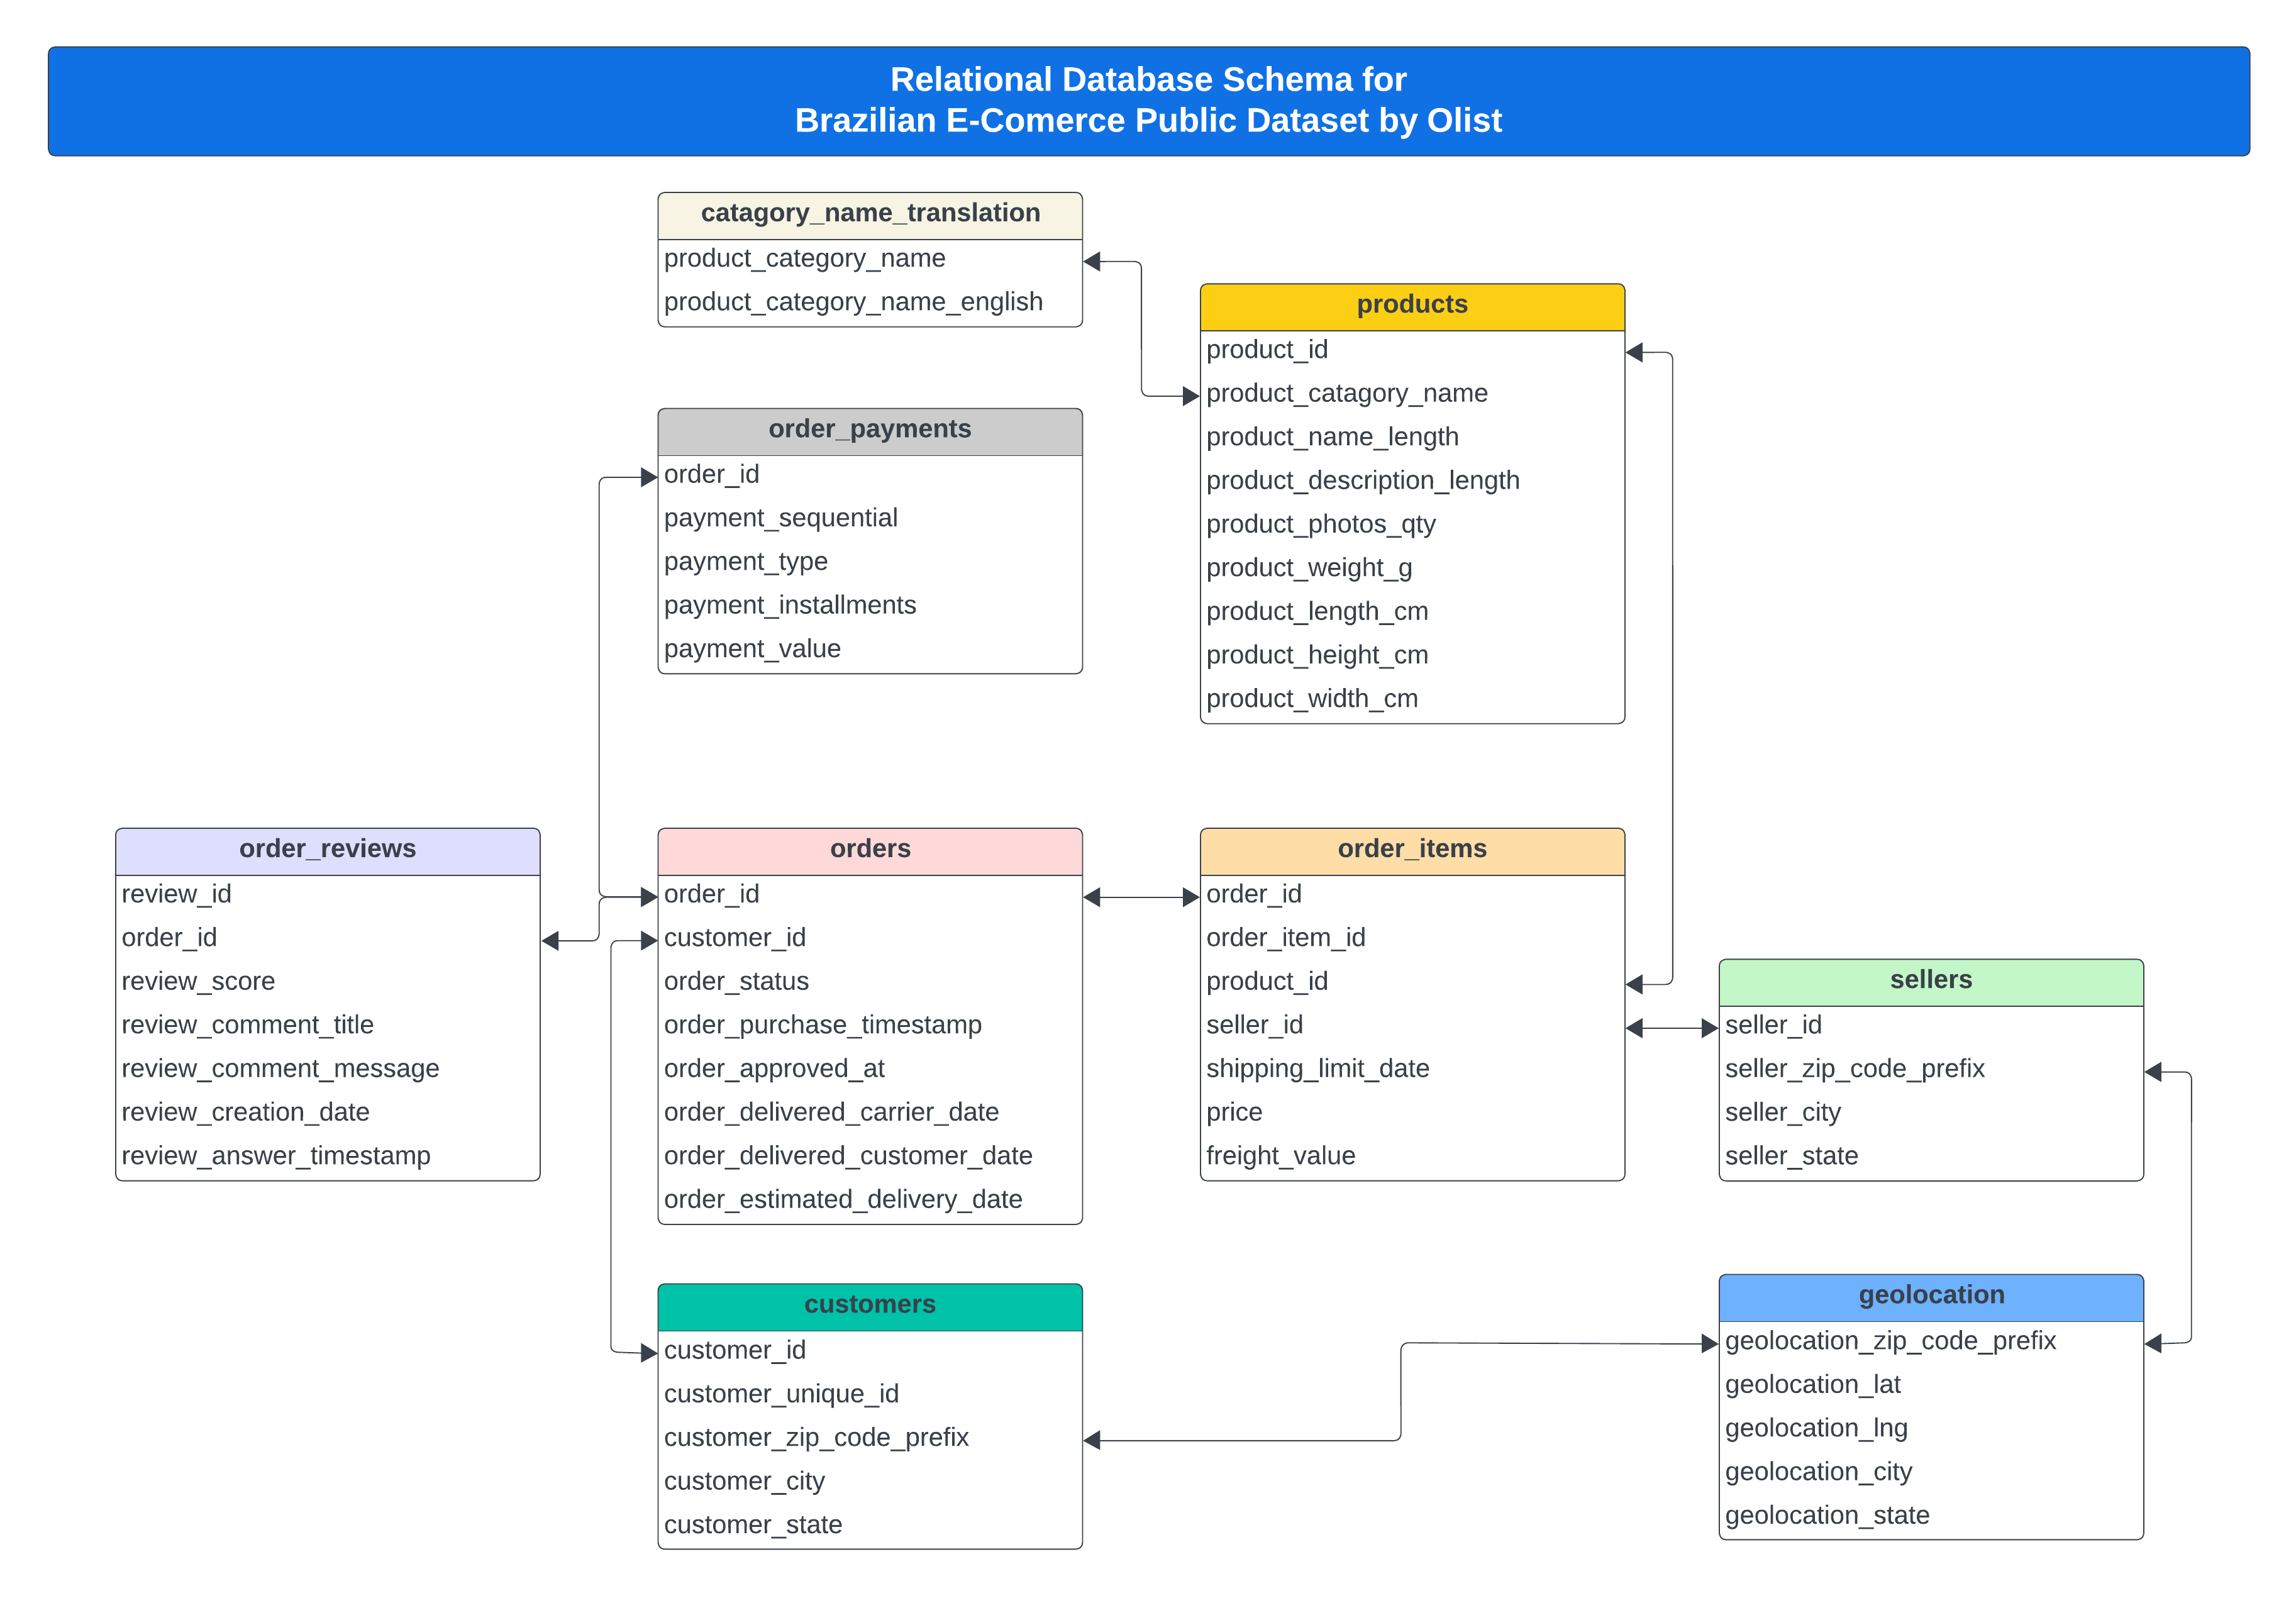

# Merging data


In [48]:
df_olist = pd.merge(df_olist_orders, df_olist_order_items, on='order_id', how='left')
df_olist = pd.merge(df_olist, df_olist_products, on='product_id', how='inner')
df_olist = pd.merge(df_olist, df_olist_order_payments, on='order_id', how = 'left')
df_olist = pd.merge(df_olist, df_olist_order_reviews, on='order_id', how='left')
df_olist = pd.merge(df_olist, df_olist_customers, on='customer_id', how='right')
df_olist = pd.merge(df_olist, df_product_category_name_translation, on='product_category_name', how='inner')

df_olist.shape

(116576, 37)

In [49]:
def display_columns_info(df):
    columns_info = []
    for col in df.columns:
        null_count = df[col].isnull().sum()
        data_type = df[col].dtype
        rows_with_values = df[col].notnull().sum()
        columns_info.append([col, null_count, data_type, rows_with_values])

    columns_info_df = pd.DataFrame(columns_info, columns=['Column Name', 'Null Amount', 'Data Type', 'Number of Rows '])
    return columns_info_df

display_columns_info(df_olist)

,Column Name,Null Amount,Data Type,Number of Rows
0,order_id,0,object,116576
1,customer_id,0,object,116576
2,order_status,0,object,116576
3,order_purchase_timestamp,0,object,116576
4,order_approved_at,14,object,116562
5,order_delivered_carrier_date,1213,object,115363
6,order_delivered_customer_date,2515,object,114061
7,order_estimated_delivery_date,0,object,116576
8,order_item_id,0,float64,116576
9,product_id,0,object,116576


In [50]:
quantity_of_orders = df_olist_orders['order_id'].nunique()
print(f'Zostało złożonych {quantity_of_orders} unikatowych zamówień')
df_olist.drop_duplicates(subset = 'order_id', inplace = True)


Zostało złożonych 99441 unikatowych zamówień


# EDA


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/3751403484.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




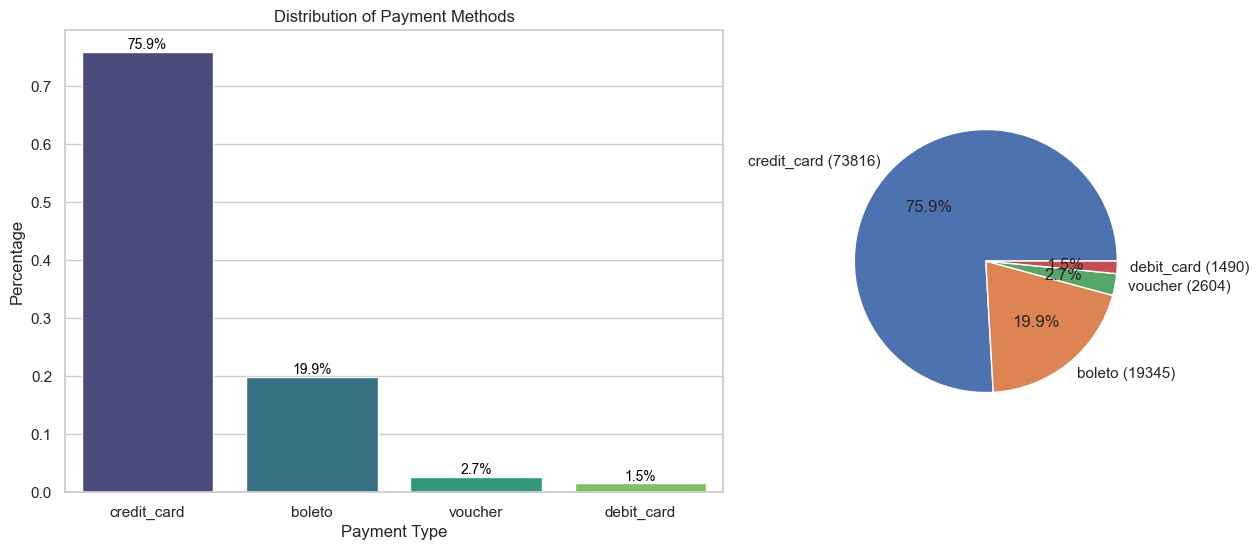

In [51]:
payment_met_counts = df_olist['payment_type'].value_counts().to_dict()
payment_met_percentages = df_olist['payment_type'].value_counts(normalize=True).reset_index()
payment_met_percentages.columns = ['Payment Type', 'Percentage']

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Wykres słupkowy
ax0 = plt.subplot(gs[0])
sns.barplot(x='Payment Type', y='Percentage', data=payment_met_percentages, palette='viridis', ax=ax0)


for p in ax0.patches:
    ax0.annotate(f"{p.get_height()*100:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

ax0.set_xlabel('Payment Type')
ax0.set_ylabel('Percentage')
ax0.set_title('Distribution of Payment Methods')

# Wykres kołowy
ax1 = plt.subplot(gs[1])
patches, texts, autotexts = ax1.pie(payment_met_counts.values(), labels=payment_met_counts.keys(), autopct='%1.1f%%', startangle=0)


for text, autotext, count in zip(texts, autotexts, payment_met_counts.values()):
    text.set_text(f"{text.get_text()} ({count})")

ax1.set_title('')

plt.show()

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/330461533.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




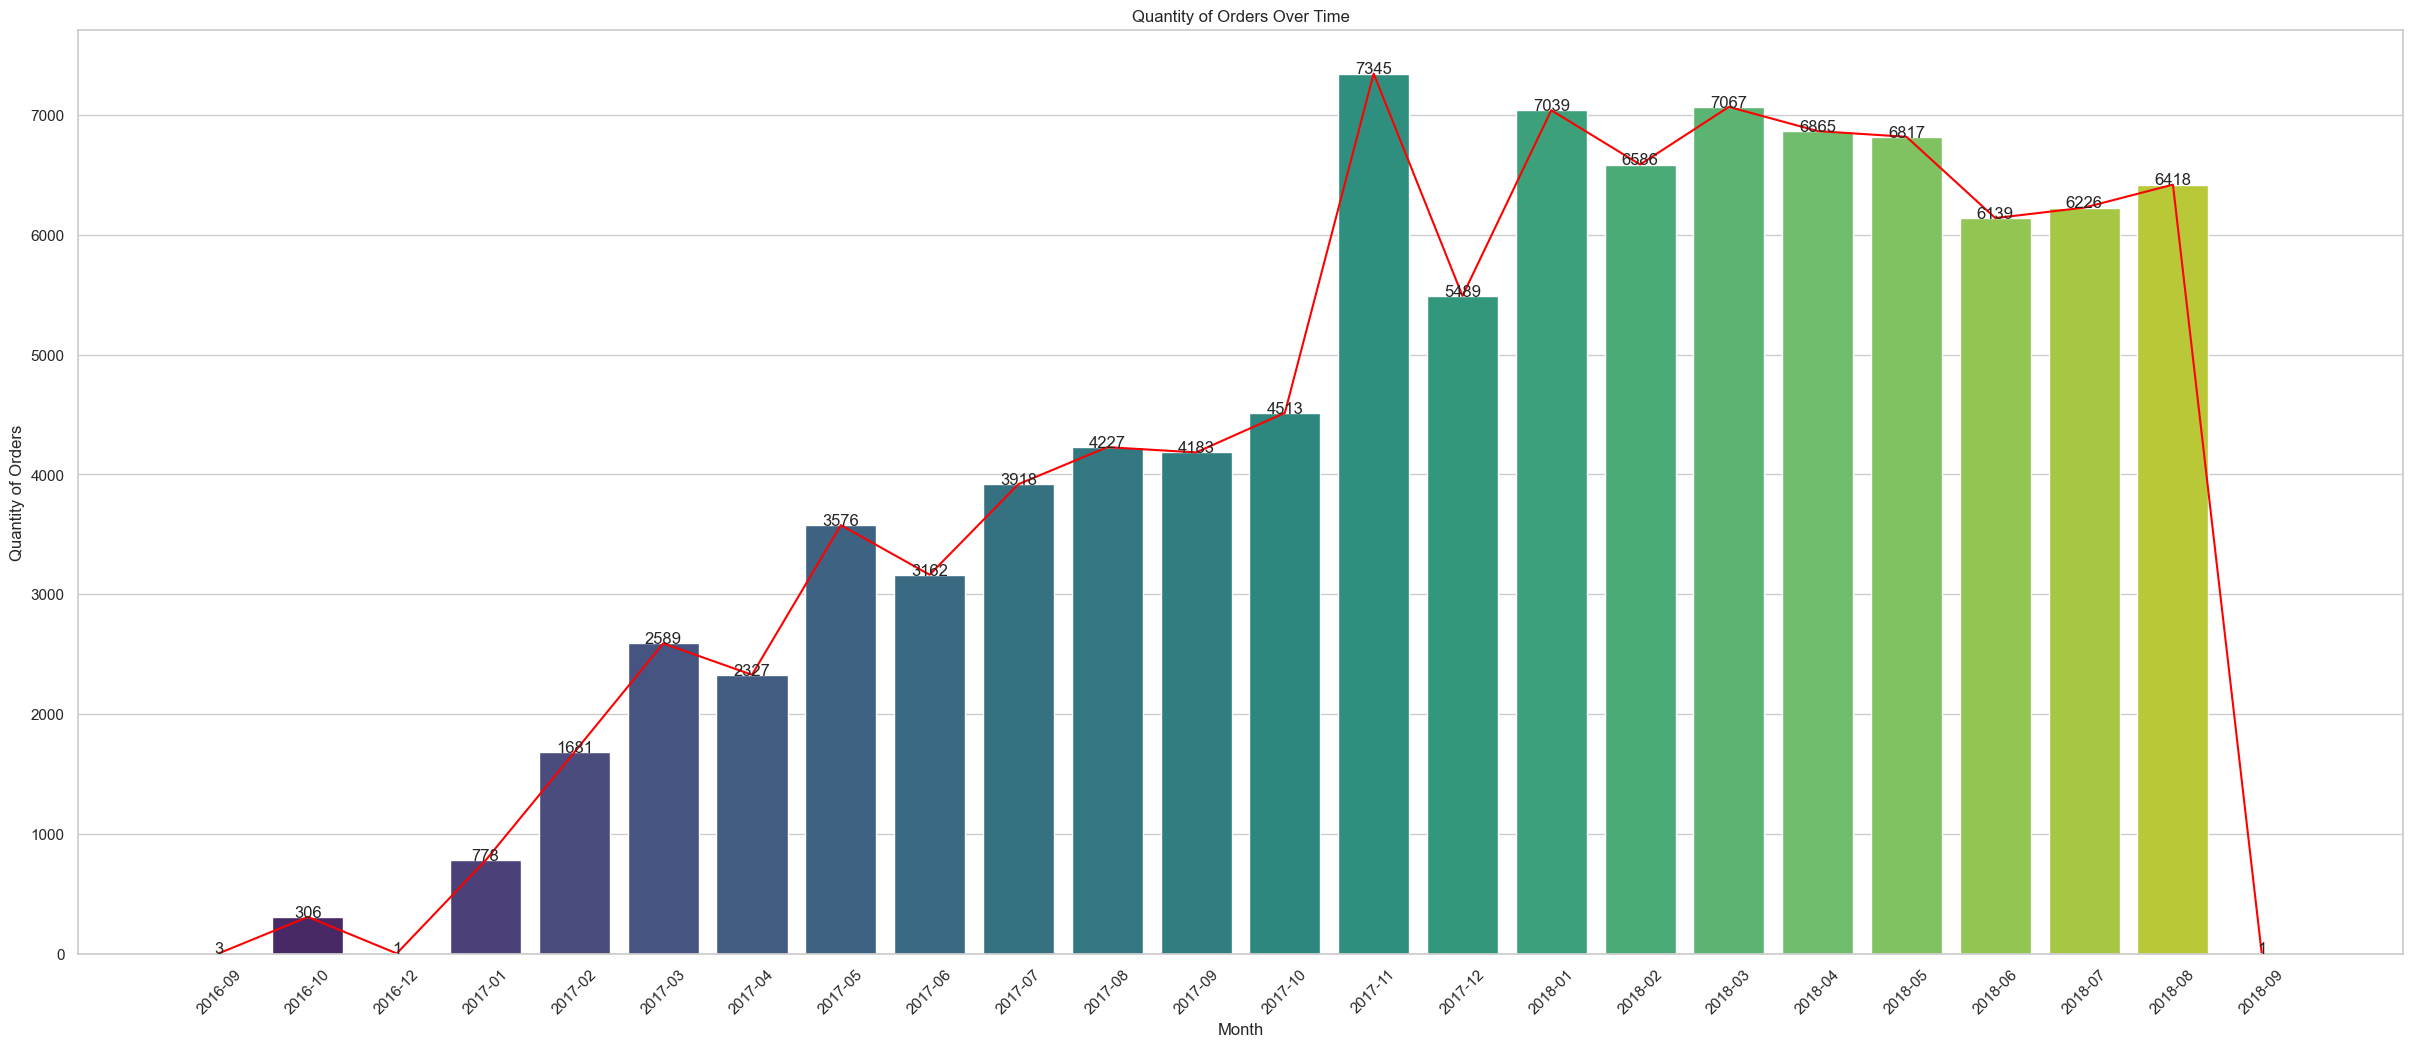

In [52]:
df_orders_quantity = df_olist[['order_purchase_timestamp', 'price']].dropna()
df_orders_quantity['quantity_of_orders'] = 1
df_orders_quantity['order_purchase_timestamp'] = pd.to_datetime(df_orders_quantity['order_purchase_timestamp'])
#sortuje dane względem daty
df_orders_quantity = df_orders_quantity.sort_values(by='order_purchase_timestamp')

# Format 'YYYY-MM'
df_orders_quantity['order_purchase_timestamp'] = df_orders_quantity['order_purchase_timestamp'].dt.to_period("M")

# pogrupowane i zsumowane zamówienia dla każdego miesiąca
df_orders_quantity = df_orders_quantity.groupby('order_purchase_timestamp').agg({'quantity_of_orders': 'sum'}).reset_index()
df_orders_quantity.rename(columns={'order_purchase_timestamp': 'Month', 'quantity_of_orders': 'Quantity of orders'}, inplace=True)

# 'Month' na string
df_orders_quantity['Month'] = df_orders_quantity['Month'].astype(str)

#  'Quantity of orders' na liczby
df_orders_quantity['Quantity of orders'] = pd.to_numeric(df_orders_quantity['Quantity of orders'], errors='coerce')


sns.set(style="whitegrid")


plt.figure(figsize=(30, 12))
barplot = sns.barplot(x='Month', y='Quantity of orders', data=df_orders_quantity, palette='viridis')

# Dodaj linię czerwoną
sns.lineplot(x='Month', y='Quantity of orders', data=df_orders_quantity, color='red', ax=barplot)

#oznaczenia nad słupkami
x = df_orders_quantity['Month']
y = df_orders_quantity['Quantity of orders']

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')


addlabels(x,y)
plt.xlabel('Month')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.show()

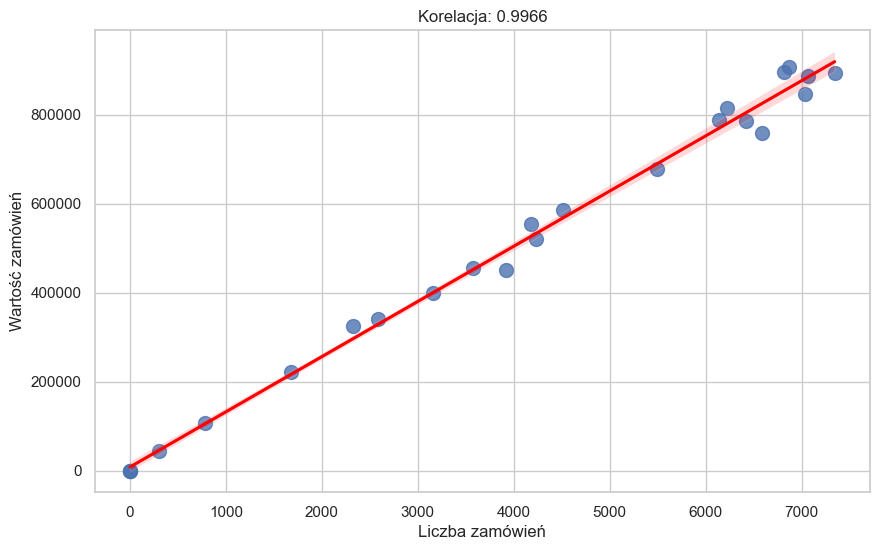

Średnia wartość koszyka zakupowego wynosi: 120.68


In [53]:
df_revenue = df_olist[['price', 'order_purchase_timestamp']]
df_revenue.rename(columns={'order_purchase_timestamp':'Month','quantity of orders	':'Quantity of orders	','price':'Revenue'}, inplace = True)

df_revenue['Month'] = df_revenue['Month'].str.slice(stop=7)
df_revenue['Quantity of orders'] = 1

df_revenue['Month'] = pd.to_datetime(df_revenue['Month'], format='%Y-%m')

# Grupuj według miesiąca i podlicz ilość zamówień i wartość zamówień
df_revenue = df_revenue.groupby(df_revenue['Month'].dt.to_period("M")).agg(
    {'Quantity of orders': 'sum', 'Revenue': 'sum'}).reset_index()

df_revenue.head(20)

correlation = df_revenue['Quantity of orders'].corr(df_revenue['Revenue'])

plt.figure(figsize=(10, 6))
sns.regplot(x='Quantity of orders', y='Revenue', data=df_revenue, scatter_kws={'s': 100}, line_kws={'color': 'red'})

plt.title(f'Korelacja: {correlation:.4f}')
plt.xlabel('Liczba zamówień')
plt.ylabel('Wartość zamówień')
plt.grid(True)
plt.show()


df_revenue['Average shopping cart'] = round( df_revenue['Revenue'] / df_revenue['Quantity of orders'] ,2)
avredge_value_of_shoppint_cart =round(df_revenue['Average shopping cart']. mean(), 2)
print(f'Średnia wartość koszyka zakupowego wynosi: {avredge_value_of_shoppint_cart}')
#df_revenue.head(30)



/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/3237349737.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




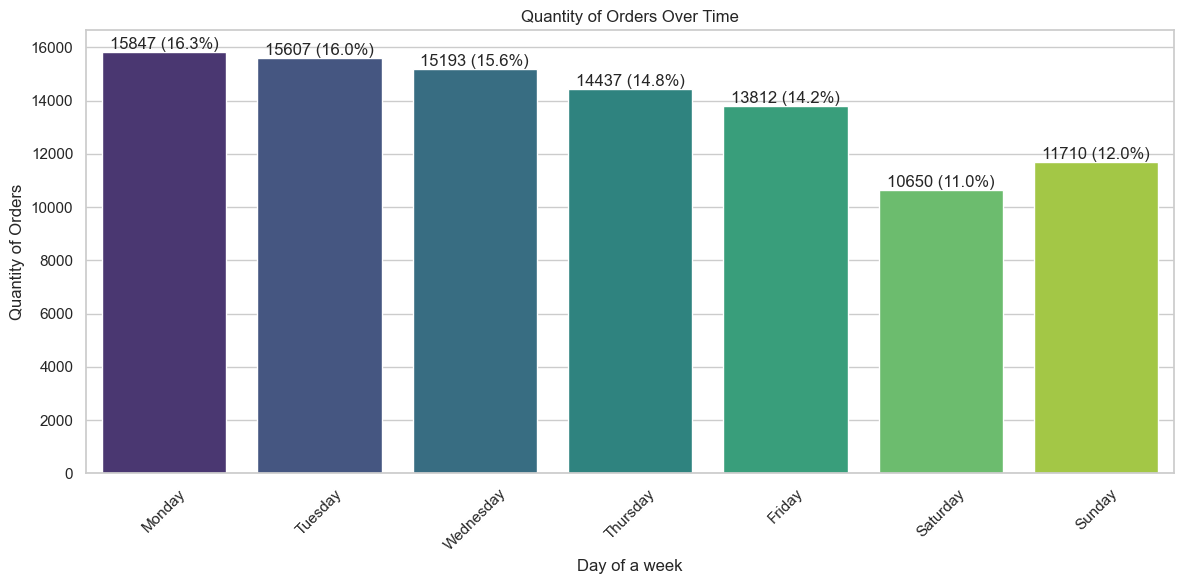

In [54]:
#new dataframe
df_daytime = df_olist[['order_id', 'order_purchase_timestamp']]
df_daytime['order_purchase_timestamp'] = pd.to_datetime(df_daytime['order_purchase_timestamp'])
df_daytime['year'] = df_daytime['order_purchase_timestamp'].dt.year
df_daytime['month'] = df_daytime['order_purchase_timestamp'].dt.month
df_daytime['day'] = df_daytime['order_purchase_timestamp'].dt.day
df_daytime['month_name'] = df_daytime['order_purchase_timestamp'].dt.strftime('%B')
df_daytime['day_name'] = df_daytime['order_purchase_timestamp'].dt.strftime('%A')
df_daytime['day_of_week'] = (df_daytime['order_purchase_timestamp'].dt.dayofweek + 1)
df_daytime['hour'] = df_daytime['order_purchase_timestamp'].dt.hour
df_daytime['timeday'] = pd.cut(df_daytime['order_purchase_timestamp'].dt.hour, bins = [0,6,12,18,24], labels = ['Dawn', 'Morning' , 'Afternoon', 'Night'])
df_daytime.head(20)

#selected columns for bar plots
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week = df_daytime.groupby('day_name')['order_id'].nunique().sort_values(ascending=False).reindex(days_order)


x = day_of_week.index
y = day_of_week.values

sns.set(style="whitegrid")
sns.set_palette('viridis')

plt.figure(figsize=(12,6))
dow_plot = sns.barplot(x=x, y=y, palette = 'viridis')



def addlabels(x,y):
    for i in range(len(x)):
         plt.text(i, y[i], f"{y[i]} ({y[i]/sum(y)*100:.1f}%)", ha='center', va='bottom')

addlabels(x,y)
plt.xlabel('Day of a week')
plt.xlabel('Day of a week')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/3655960510.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



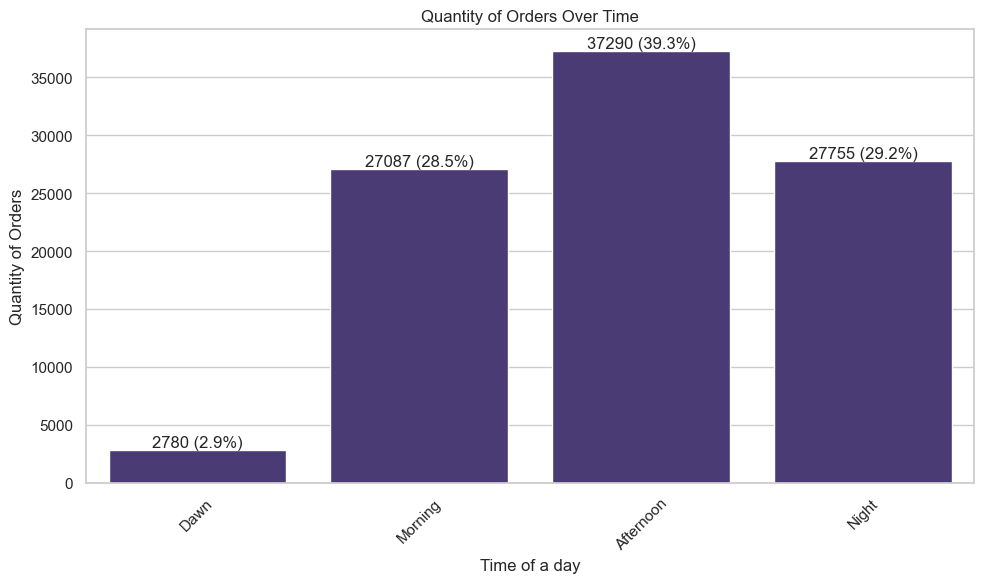

timeday
Dawn          2780
Morning      27087
Afternoon    37290
Night        27755
Name: order_id, dtype: int64


In [55]:
time_of_day = df_daytime.groupby('timeday')['order_id'].nunique()

#plot
sns.set(style="whitegrid")
sns.set_palette('viridis')


x = time_of_day.index
y = time_of_day.values

# wykres
plt.figure(figsize=(10, 6))
tod_plot = sns.barplot(x=x, y=y)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], f"{y[i]} ({y[i]/sum(y)*100:.1f}%)", ha='center', va='bottom')

# etykiety i tytuł
addlabels(x,y)
plt.xlabel('Time of a day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(time_of_day)

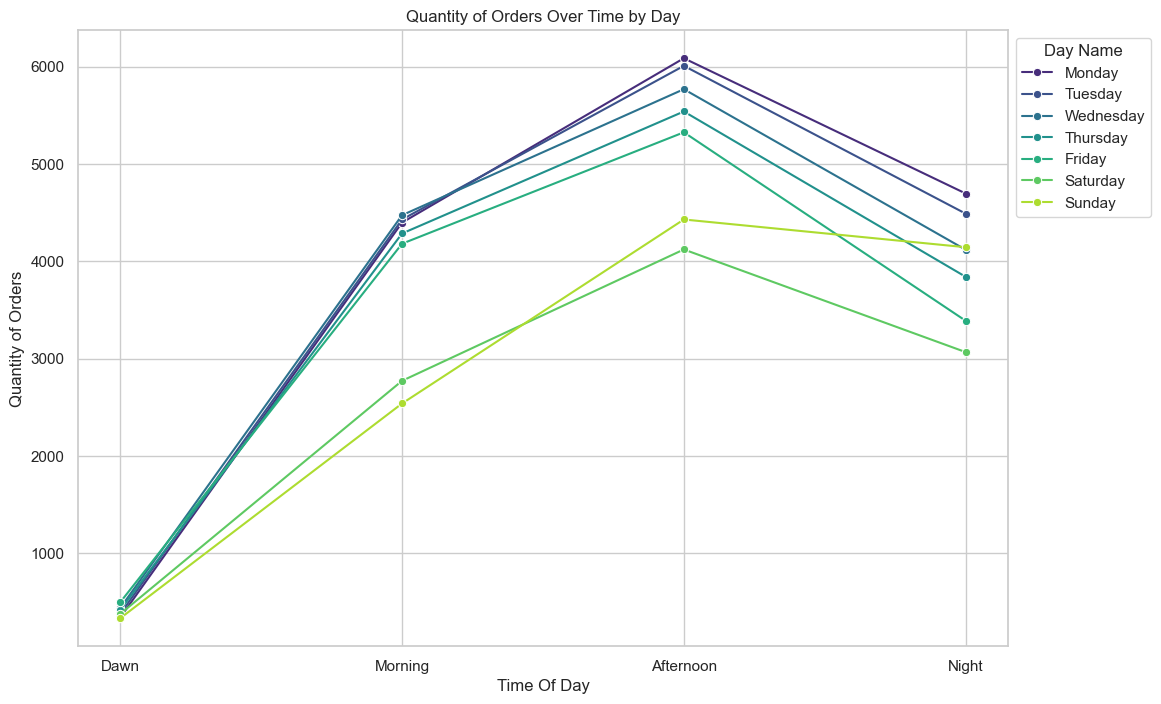

In [56]:
df_weekly = df_daytime[['order_id','day_name','timeday','day', ]]
df_weekly['Combined'] = df_weekly['day_name'].str.cat(df_weekly['timeday'], sep=' ')
df_weekly_combined = df_weekly.groupby('Combined')[['order_id']].nunique().reset_index().rename(columns={'order_id':'Quantity of orders'})
df_weekly_combined[['Day Name', 'Time Of Day']] = df_weekly_combined['Combined'].str.split(expand = True, n=1)

sort_days = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
sort_time = {'Dawn':1, 'Morning':2, 'Afternoon':3, 'Night':4}

df_weekly_combined['Sort by day'] = df_weekly_combined['Day Name'].map(sort_days)
df_weekly_combined['Sort by time'] = df_weekly_combined['Time Of Day'].map(sort_time)

df_weekly_combined.sort_values(by=["Sort by day", "Sort by time"],ascending=True, inplace = True)
df_weekly_combined.drop(columns=["Sort by day", "Sort by time"], inplace = True)


days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Dawn', 'Morning', 'Afternoon', 'Night']


df_plot = df_weekly_combined[df_weekly_combined['Day Name'].isin(days_order)]
df_plot = df_plot[df_plot['Time Of Day'].isin(time_order)]

sns.set(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=len(days_order))


plt.figure(figsize=(12, 8))
sns.lineplot(x='Time Of Day', y='Quantity of orders', hue='Day Name', data=df_plot, palette=palette, marker='o')


plt.xlabel('Time Of Day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time by Day')


plt.legend(title='Day Name', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

<Figure size 1200x800 with 0 Axes>

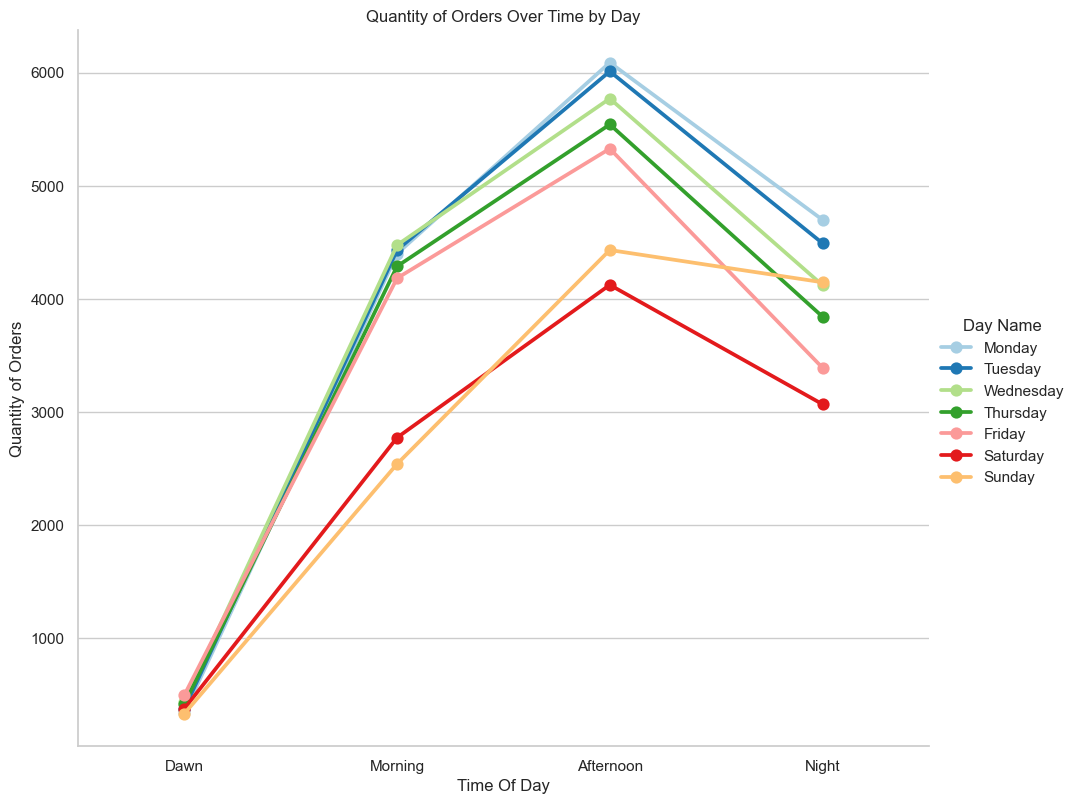

In [57]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Dawn', 'Morning', 'Afternoon', 'Night']


df_plot = df_weekly_combined[df_weekly_combined['Day Name'].isin(days_order)]
df_plot = df_plot[df_plot['Time Of Day'].isin(time_order)]


sns.set(style="whitegrid")
palette = sns.color_palette("Paired", n_colors=len(days_order))


plt.figure(figsize=(12, 8))
sns.catplot(x='Time Of Day', y='Quantity of orders', hue='Day Name', data=df_plot, kind='point', palette=palette, height=8, aspect=1.2)


plt.xlabel('Time Of Day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time by Day')


plt.show()


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/1523777670.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/1523777670.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/1523777670.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



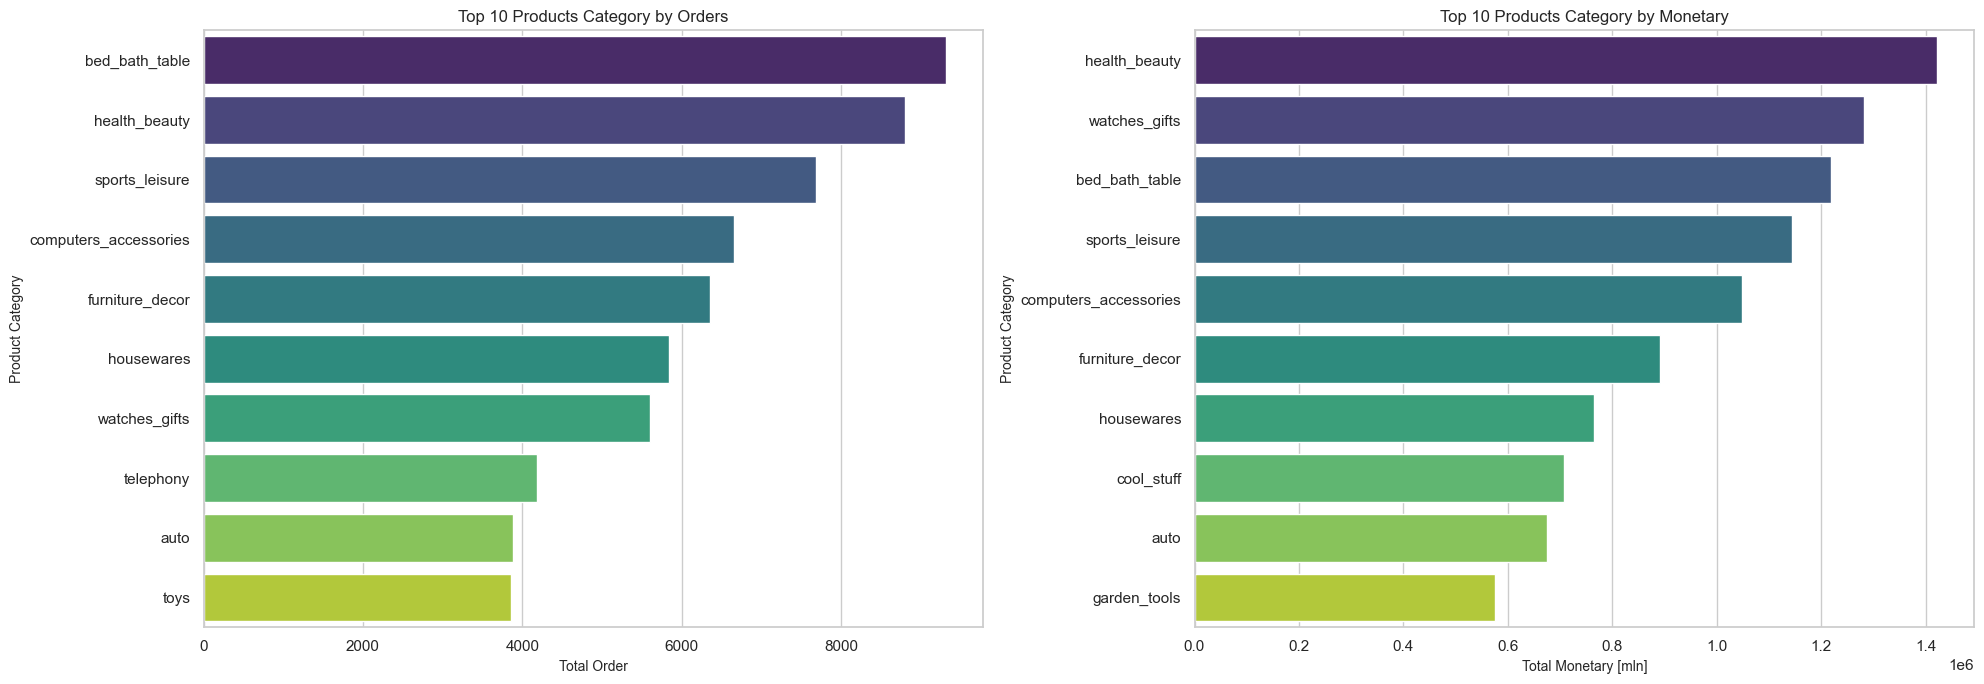

In [58]:
# Group by top 10 products category by Total Order and Total Monetary
products_by_order = df_olist.groupby('product_category_name_english').count()[['order_id']].sort_values(by='order_id', ascending=False).reset_index()[:10]
product_by_payment_value = df_olist.groupby('product_category_name_english').sum()[['payment_value']].sort_values(by='payment_value', ascending=False).reset_index()[:10]

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(20,7))

sns.barplot(data=products_by_order, x='order_id', y='product_category_name_english', palette='viridis', ax=ax[0])
ax[0].set_title("Top 10 Products Category by Orders", fontdict={'fontsize':12})
ax[0].set_xlabel("Total Order", fontdict={'fontsize':10})
ax[0].set_ylabel("Product Category", fontdict={'fontsize':10})


sns.barplot(data=product_by_payment_value, x='payment_value', y='product_category_name_english', palette="viridis", ax=ax[1])
ax[1].set_title("Top 10 Products Category by Monetary", fontdict={'fontsize':12})
ax[1].set_xlabel("Total Monetary [mln]", fontdict={'fontsize':10})
ax[1].set_ylabel("Product Category", fontdict={'fontsize':10})

fig.tight_layout()
fig.show()

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/644544087.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/644544087.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/644544087.py:23: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



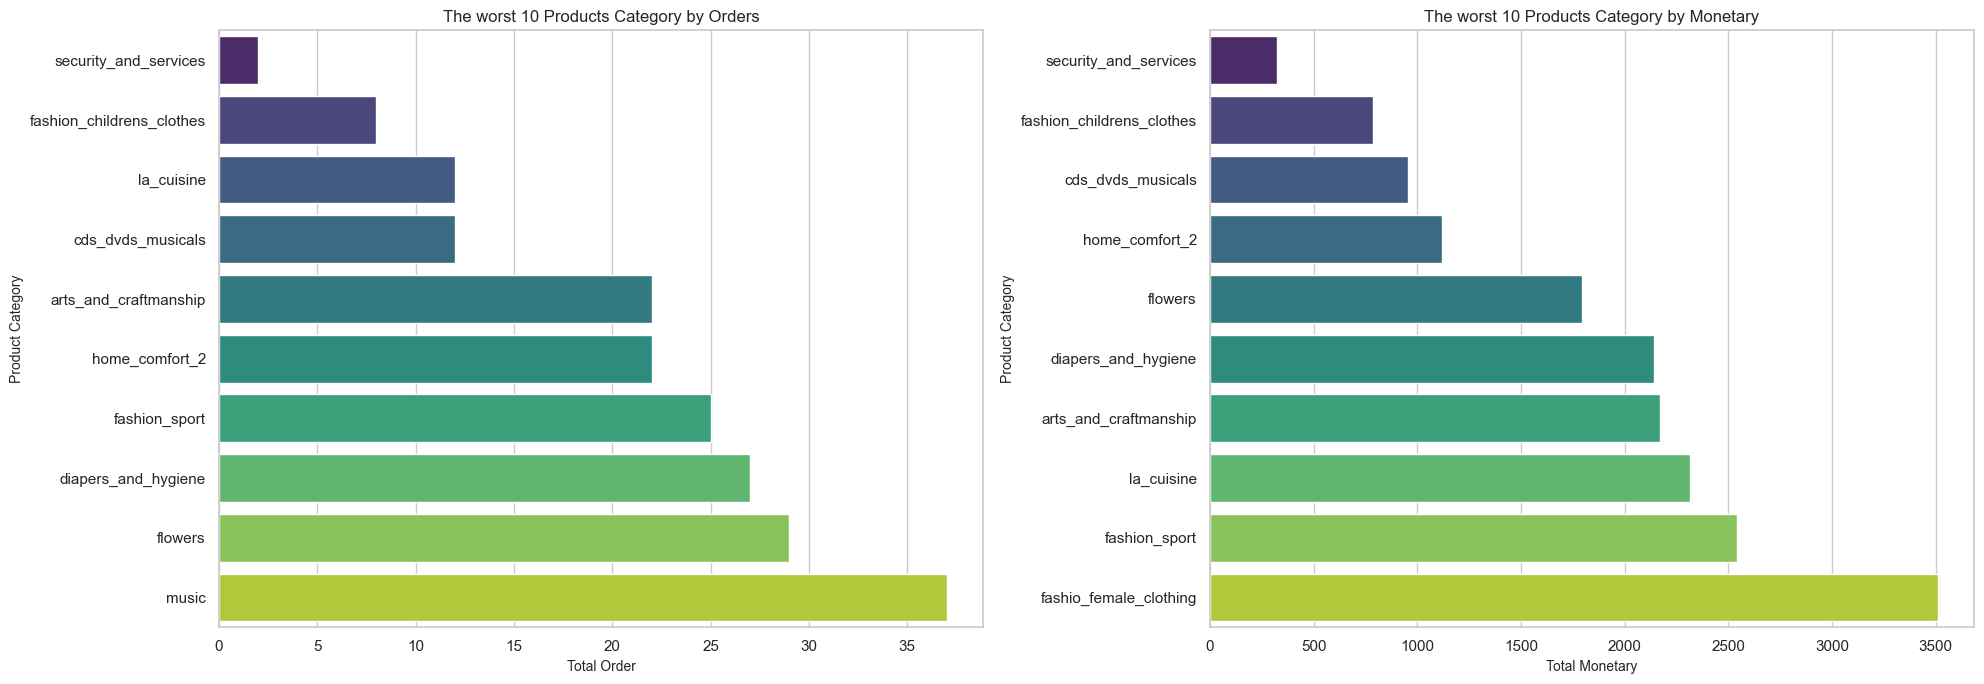

In [59]:
# Group by the worst 10 products category by Total Order and Total Monetary
products_by_order = df_olist.groupby('product_category_name_english').count()[['order_id']].sort_values(by='order_id', ascending=True).reset_index()[:10]
product_by_payment_value = df_olist.groupby('product_category_name_english').sum()[['payment_value']].sort_values(by='payment_value', ascending=True).reset_index()[:10]

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(20,7))

sns.barplot(data=products_by_order, x='order_id', y='product_category_name_english', palette='viridis', ax=ax[0])
ax[0].set_title("The worst 10 Products Category by Orders", fontdict={'fontsize':12})
ax[0].set_xlabel("Total Order", fontdict={'fontsize':10})
ax[0].set_ylabel("Product Category", fontdict={'fontsize':10})


sns.barplot(data=product_by_payment_value, x='payment_value', y='product_category_name_english', palette="viridis", ax=ax[1])
ax[1].set_title("The worst 10 Products Category by Monetary", fontdict={'fontsize':12})
ax[1].set_xlabel("Total Monetary", fontdict={'fontsize':10})
ax[1].set_ylabel("Product Category", fontdict={'fontsize':10})

# Make sure layout is not overlapping
fig.tight_layout()

fig.show()

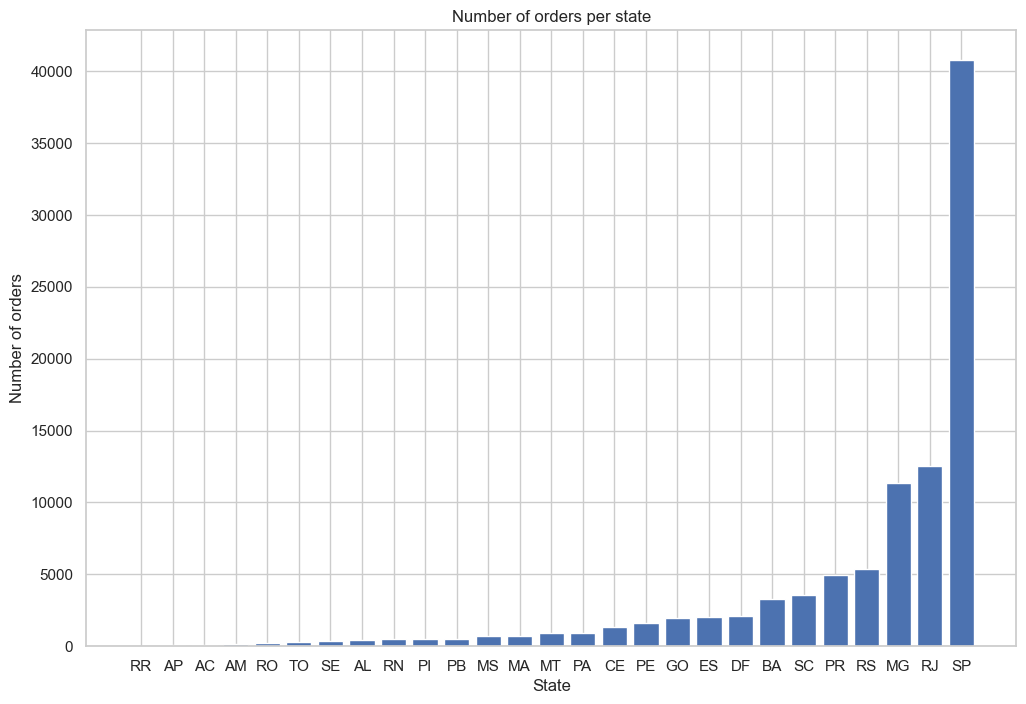

In [60]:
customer_by_state = df_olist[['customer_unique_id', 'customer_state']].groupby('customer_state').count().reset_index()
customer_by_state = customer_by_state.sort_values(by=['customer_unique_id'])

plt.figure(figsize=(12,8))
plt.bar(customer_by_state['customer_state'], customer_by_state['customer_unique_id'])
plt.xlabel('State')
plt.ylabel('Number of orders')
plt.title('Number of orders per state')
plt.show()

# Kohorts


In [ ]:
df_segmentation_time = df_olist[['order_purchase_timestamp', 'customer_unique_id', 'order_id', 'price']]
# Konwertuję kolumnę 'order_purchase_timestamp' na format daty, następnie filtruje, aby DF zawierał tylko dane z okresu 1.1.2017 - 31.8.2018
df_segmentation_time['order_purchase_timestamp'] = pd.to_datetime(df_segmentation_time['order_purchase_timestamp'])
df_segmentation_time = df_segmentation_time[(df_segmentation_time['order_purchase_timestamp'] >= '2017-01-01')
& (df_segmentation_time['order_purchase_timestamp'] <= '2018-08-31')]

min_date = df_segmentation_time['order_purchase_timestamp'].min()
max_date = df_segmentation_time['order_purchase_timestamp'].max()
print(f"Najwcześniejsza data: {min_date}, Najnowsza data: {max_date}")

def display_null_counts(df):
    for col in df.columns:
      null_count = df[col].isnull().sum()
      print(f'Kolumna {col} ma {null_count} watości null.')
    print(f'Kształt DataFrame: {df.shape}')

display_null_counts(df_segmentation_time)

In [ ]:
#Wybieram kolumne z unikalnym ID klienta aby sprawdzić ilu ich jest oraz obliczyć ile jest zamówień powracających.
unique_clientsID = df_segmentation_time['customer_unique_id'].nunique()
clientsID_in_DF = df_segmentation_time['customer_unique_id'].count()

multi_order_customers = df_segmentation_time['customer_unique_id'].duplicated(keep=False)
multi_order_orders = df_segmentation_time[multi_order_customers].shape[0]
percent = ((multi_order_orders / unique_clientsID)*100)
rounded = round(percent, 3)

print(f'Ogólna liczba ID klientów to : {clientsID_in_DF}.')
print(f'Liczba unikatowych ID to : {unique_clientsID}.')
print(f'Procent powracających klientów: {rounded} % ')
print(f'Liczba zamowien od klientów, którzy dokonali zamówienia ponad 1 raz: {multi_order_orders}')

In [ ]:
#Zostawiam tylko zduplikowane wiersze z 'customer_unique_id' ponieważ są to klienci, którzy zrobili zamówienie więcej niż 1 raz
multi_order_customers = df_segmentation_time['customer_unique_id'].value_counts() > 1
multi_order_customers = multi_order_customers[multi_order_customers].index
df_seg_time = df_segmentation_time[df_segmentation_time['customer_unique_id'].isin(multi_order_customers)]


def get_month(x) :
   return dt.datetime(x.year, x.month, 1)

# Tworzę nową kolumnę 'OrderMonth', która zawiera pierwszy dzień miesiąca z kolumny 'order_purchase_timestamp'
df_seg_time['OrderMonth'] = df_seg_time['order_purchase_timestamp'].apply(get_month)
# Grupuję dane według 'customer_unique_id' i wybieram najwcześniejszy 'OrderMonth' dla każdego klienta
grouping = df_seg_time.groupby('customer_unique_id')['OrderMonth']
df_seg_time['AcquisitionMonth'] = grouping.transform('min')

df_seg_time.shape

In [ ]:
def get_date_int (df, column):
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year, month, day

order_year, order_month, _ = get_date_int(df_seg_time, 'OrderMonth')
acqusiition_year, acqusiition_month, _ = get_date_int(df_seg_time, 'AcquisitionMonth')
# Calculating the difference in years and months between 'OrderMonth' and 'AcquisitionMonth'
years_diff = order_year - acqusiition_year
months_diff = order_month - acqusiition_month
# Calculating the cohort index by converting the differences in years and months to the number of months and adding 1 to get the cohort index
df_seg_time['CohortIndex'] = years_diff * 12 + months_diff + 1

grouping = df_seg_time.groupby(['AcquisitionMonth', 'CohortIndex'])
# Creating the `cohort_counts` DataFrame where the values from the 'customer_unique_id' column are converted to the number of customers in the cohort 
# Rows represent the acquisition months and columns represent the subsequent months from acquisition.

cohort_data = grouping['customer_unique_id'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index= 'AcquisitionMonth',
                                  columns = 'CohortIndex',
                                  values = 'customer_unique_id')
cohort_counts


In [ ]:
# Calculating the cohort size as the number of customers in the first month, then dividing each subsequent period by the number from the first period
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.loc['2017-01-01'] = retention.loc['2017-01-01'].fillna(0)
retention.round(2)*100

In [ ]:
#calculating the average price value for each cohort
grouping = df_seg_time.groupby(['AcquisitionMonth', 'CohortIndex' ])
cohort_data = grouping['price'].mean()
cohort_data = cohort_data.reset_index()
avrege_quantity = cohort_data.pivot(index = 'AcquisitionMonth',
                                    columns = 'CohortIndex',
                                    values = 'price')
avrege_quantity.round(1)


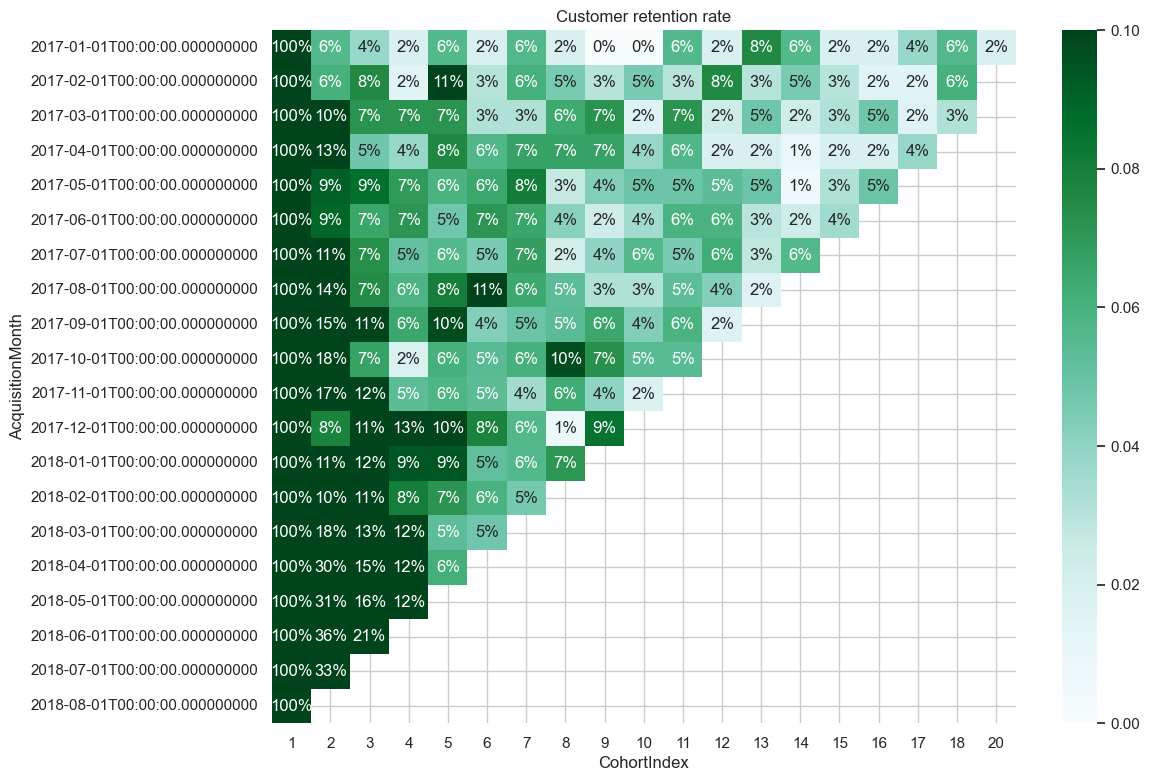

In [67]:
plt.figure(figsize = (12,9))
plt.title('Customer retention rate')
sns.heatmap(data=retention,
            annot = True,
            fmt = '.0%',
            vmin = 0,
            vmax = 0.10,
            cmap = 'BuGn')
plt.show()

#RFM


In [ ]:
last_day = max(df_segmentation_time.order_purchase_timestamp) + dt.timedelta(days = 1 )

datamart = df_segmentation_time.groupby(['customer_unique_id']).agg({
    'order_purchase_timestamp':lambda x: (last_day - x.max()).days,     # Calculating the number of days from the last order to the end date of the analysis (Recency)
    'order_id' : 'count',
    'price' : 'sum'
})
datamart.rename(columns = {
                           'order_purchase_timestamp': 'Recency',
                           'order_id': 'Frequency',
                           'price':'MonetaryValue'}, inplace = True)
datamart = datamart.rename_axis('CustomerID')
datamart.head(10)

In [ ]:
datamart['Frequency'].value_counts()

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/3008764069.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/3008764069.py:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/3

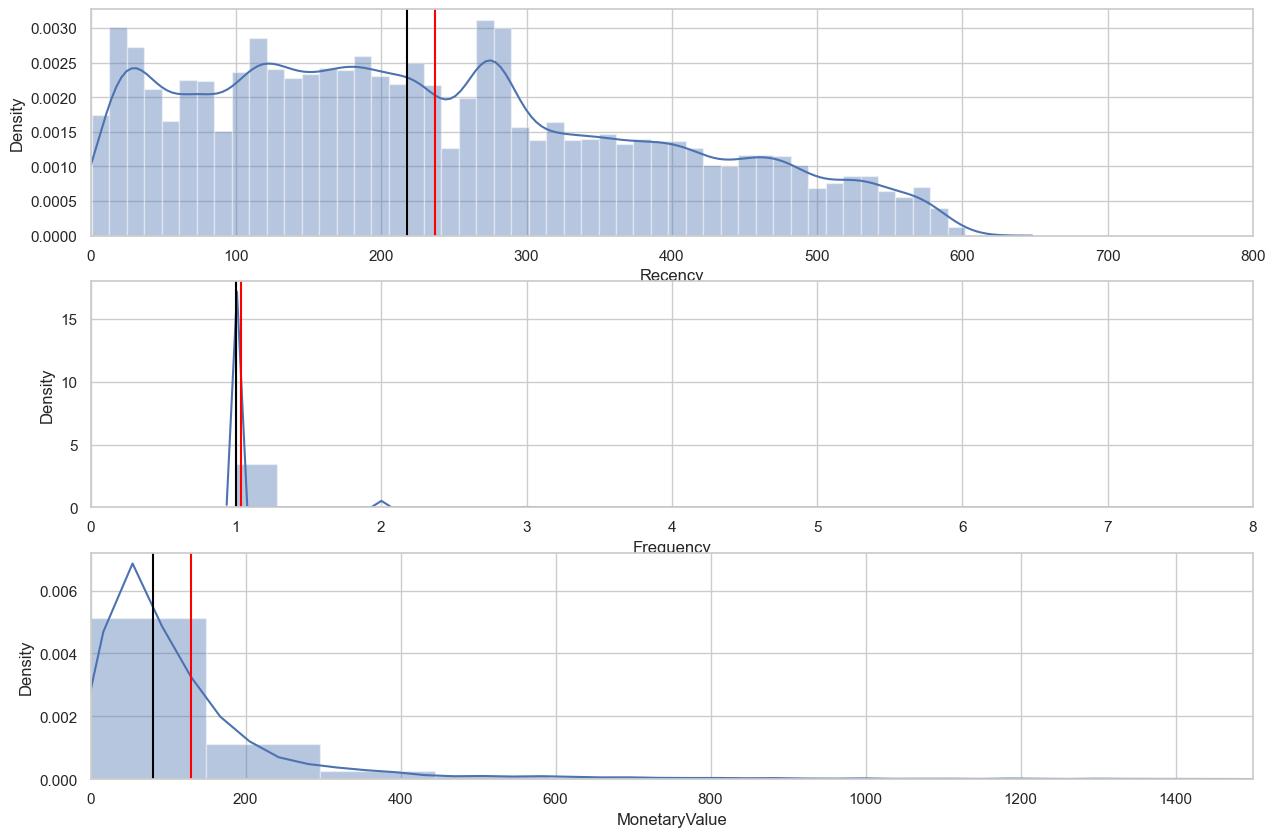

In [70]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1); sns.distplot(datamart['Recency']),
plt.axvline(datamart['Recency'].mean(), c = 'red')
plt.axvline(datamart['Recency'].median(), c = 'black')
plt.xlim(0, 800)

plt.subplot(3, 1, 2); sns.distplot(datamart['Frequency'])
plt.axvline(datamart['Frequency'].mean(), c = 'red')
plt.axvline(datamart['Frequency'].median(), c = 'black')
plt.xlim(0, 8)

plt.subplot(3, 1, 3); sns.distplot(datamart['MonetaryValue'])
plt.axvline(datamart['MonetaryValue'].mean(), c = 'red')
plt.axvline(datamart['MonetaryValue'].median(), c = 'black')
plt.xlim(0, 1500)

plt.show()

In [71]:
rfm_datamart = datamart.copy()

r_labels = range(4, 0, -1)
m_labels = range(1,5)

r_quartiles = pd.qcut(rfm_datamart['Recency'], q=4, labels = r_labels)
def adjust_frequency(row):
    if row['Frequency'] == 1:
        return 1
    elif row['Frequency'] == 2:
        return 2
    elif row['Frequency'] == 3:
        return 3
    else:
        return 4
m_quartiles = pd.qcut(rfm_datamart['MonetaryValue'], q=4, labels = m_labels)

rfm_datamart = rfm_datamart.assign(R = r_quartiles.values)
rfm_datamart = rfm_datamart.assign(F = rfm_datamart.apply(adjust_frequency, axis=1))
rfm_datamart = rfm_datamart.assign(M = m_quartiles.values)

rfm_datamart = rfm_datamart[['Recency', 'Frequency', 'MonetaryValue', 'R', 'F', 'M']]

def join_rfm(x):
    return ''.join(map(str, [int(x['R']), int(x['F']), int(x['M'])]))

rfm_datamart['RFM_segment'] = rfm_datamart.apply(join_rfm, axis = 1)
rfm_datamart['RFM_score'] = rfm_datamart[['R', 'F', 'M']].sum(axis = 1)


rfm_datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
CustomerID,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,3,413,8
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311,5
0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,4
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,4
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214,7


In [ ]:
rfm_datamart.groupby('RFM_segment').size().sort_values(ascending = False)[:20]

In [73]:
rfm_datamart.groupby('RFM_score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']}).round(1)


Recency Frequency MonetaryValue       
             mean      mean          mean  count
RFM_score                                       
3           452.9       1.0          26.8   5946
4           361.0       1.0          43.9  11604
5           297.0       1.0          64.7  17494
6           234.1       1.0         129.8  22830
7           169.6       1.0         160.3  17488
8           116.6       1.1         211.7  11861
9            67.1       1.1         323.4   6047
10           70.2       2.1         323.0    438
11           83.6       3.5         421.1     60
12           53.1       5.0         588.8     23

In [ ]:
datamart['Frequency'].value_counts()

In [75]:
def segment_client(df):
    if df['RFM_score'] >= 9:
        return 'High segment'
    elif  (6 <= df['RFM_score'] < 9):
        return 'Medium segment'
    else:
        return 'Low segment'

rfm_datamart['General_segment'] = rfm_datamart.apply(segment_client, axis=1)
custom_order = ['High segment', 'Medium segment', 'Low segment']
rfm_datamart['General_segment'] = pd.Categorical(rfm_datamart['General_segment'], categories=custom_order, ordered=True)

result = rfm_datamart.groupby('General_segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

result = result.loc[custom_order]
result

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_19230/675143264.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Recency Frequency MonetaryValue       
                   mean      mean          mean  count
General_segment                                       
High segment       67.4       1.2         325.2   6568
Medium segment    185.8       1.0         158.6  52179
Low segment       344.6       1.0          51.4  35044

In [76]:
def segment_client(df):
    rfm = f"{df['R']}{df['F']}{df['M']}"
    
    segment_rules = [
        ('Champions', {'444'}),
        ('Loyal Customers', {'443', '434', '344'}),
        ('Potential Loyalists', {'433', '424', '343', '334', '323', '244', '234', '223'}),
        ('New Customers', {'411', '412', '421', '422', '431', '432'}),
        ('Promising', {'311', '312', '313', '314', '321', '322', '324'}),
        ('Need Attention', {'211', '212', '213', '214', '221', '222', '224'}),
        ('At Risk', {'111', '112', '113', '114', '121', '122', '123', '124'}),
        ('High Value Risk', {'441', '442', '414', '413', '341', '342', '333', '332', '331', '423'}),
        ('Low Value Risk', {'243', '242', '241', '233', '232', '231', '143', '142', '141', '134', '133', '132', '131'})
    ]
    
    for segment, values in segment_rules:
        if rfm in values:
            return segment
    
    return 'Other'

# Przypisanie segmentów klientom
rfm_datamart['Segment'] = rfm_datamart.apply(segment_client, axis=1)

# Obliczenie liczby klientów w każdym segmencie
segment_counts = rfm_datamart['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Obliczenie procentowego udziału
total_count = segment_counts['Count'].sum()
segment_counts['Percentage'] = (segment_counts['Count'] / total_count) * 100

 #Wyświetlenie tabeli z procentowym udziałem
result = rfm_datamart.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
result.columns = ['Recency_mean', 'Frequency_mean', 'MonetaryValue_mean', 'Count']
result = result.reset_index()

# Dodanie procentowego udziału do tabeli
result['Percentage'] = (result['Count'] / result['Count'].sum() * 100).round(2)
result

,Segment,Recency_mean,Frequency_mean,MonetaryValue_mean,Count,Percentage
0,At Risk,448.5,1.0,131.8,23399,24.95
1,Champions,53.1,5.0,588.8,23,0.02
2,High Value Risk,58.5,1.0,216.8,11325,12.07
3,Low Value Risk,424.9,3.1,230.4,48,0.05
4,Loyal Customers,83.6,3.5,421.1,60,0.06
5,Need Attention,276.5,1.0,127.0,23141,24.67
6,New Customers,56.6,1.0,44.2,11836,12.62
7,Other,558.0,4.0,399.7,1,0.00
8,Potential Loyalists,147.6,2.1,230.0,863,0.92
9,Promising,165.9,1.0,128.2,23095,24.62


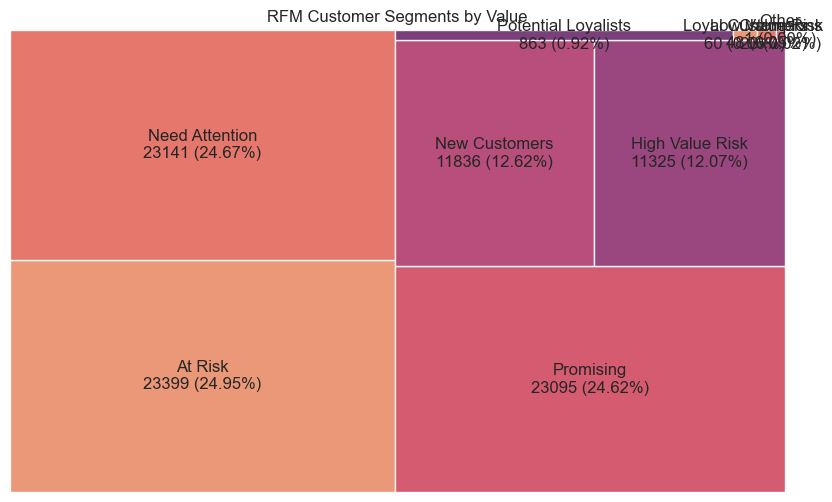

In [77]:
plt.figure(figsize=(10, 6))
squarify.plot(
    sizes=segment_counts['Count'],
    label=[f"{row['Segment']}\n{row['Count']} ({row['Percentage']:.2f}%)" for _, row in segment_counts.iterrows()],
    color=sns.color_palette("flare"),
    alpha=0.9
)
plt.title('RFM Customer Segments by Value')
plt.axis('off')
plt.show()

# RFM Segment Analysis

## Wyjaśnienia segmentów

- **Champions**: Klienci o najwyższych ocenach R, F i M. Są to najwartościowsi klienci, którzy regularnie dokonują zakupów i wydają dużo pieniędzy.
- **Loyal Customers**: Klienci o wysokich ocenach R i F oraz M. To stali klienci, którzy często dokonują zakupów.
- **Potential Loyalists**: Klienci o średnich do wysokich ocenach R, F i M. Są to klienci, którzy mogą stać się lojalnymi klientami.
- **New Customers**: Nowi klienci, którzy dokonali pierwszych zakupów. Mają niską ocenę F i różną ocenę M.
- **Promising**: Klienci o dobrych ocenach M, ale niekoniecznie R i F. Są to klienci, którzy mają potencjał do stania się wartościowymi.
- **Need Attention**: Klienci o średnich ocenach we wszystkich trzech metrykach. Wymagają większej uwagi, aby zwiększyć ich wartość.
- **At Risk**: Klienci, którzy kiedyś byli wartościowi, ale teraz są mniej aktywni. Mają wysoką ocenę R, niską F i średnią M.
- **High Value Risk**: Klienci o wysokiej wartości zakupów (M), ale niskiej ostatniości (R) lub częstotliwości (F). Wydają dużo pieniędzy, ale są mniej aktywni.
- **Low Value Risk**: Klienci o niskiej wartości zakupów (M), niskiej ostatniości (R) i niskiej częstotliwości (F). Wydają mało pieniędzy i są mniej aktywni.


# Data preprocessing to alghoritm Kmeans


In [78]:
datamart.describe().round(2)

,Recency,Frequency,MonetaryValue
count,93791.00,93791.00,93791.00
mean,236.83,1.03,130.20
std,151.25,0.21,196.95
min,1.00,1.00,0.85
25%,114.00,1.00,43.90
50%,218.00,1.00,79.90
75%,345.00,1.00,144.99
max,602.00,15.00,7388.00


In [80]:
scaler = StandardScaler()
scaler.fit(datamart)
datamart_normalized = scaler.transform(datamart)
columns_name = ['Recency', 'Frequency', 'MonetaryValue']
X = pd.DataFrame(datamart_normalized, columns = columns_name)
X.describe().round(2)

,Recency,Frequency,MonetaryValue
count,93791.00,93791.00,93791.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-1.56,-0.16,-0.66
25%,-0.81,-0.16,-0.44
50%,-0.12,-0.16,-0.26
75%,0.72,-0.16,0.08
max,2.41,66.87,36.85


# Kmeans


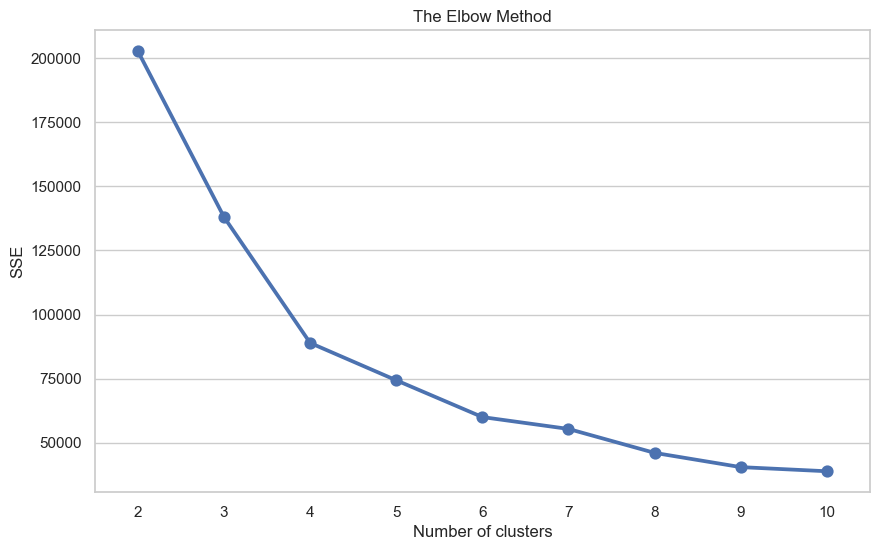

In [82]:
#Elbow Curve

sse = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9 ,10]

for num_clusters in range_n_clusters:
    kmeans =KMeans(n_clusters=num_clusters, max_iter= 50, random_state= 42)
    kmeans.fit(X)

    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
sns.pointplot(x=range_n_clusters, y=sse, markers='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
#Silhouette Analysis
silhouette_scores = []

for num_clusters in range_n_clusters:
    kmeans =KMeans(n_clusters=num_clusters, max_iter= 50, random_state= 42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    #silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print('For n_clusters = {0}, the silhouette score is {1}'. format(num_clusters, silhouette_avg))

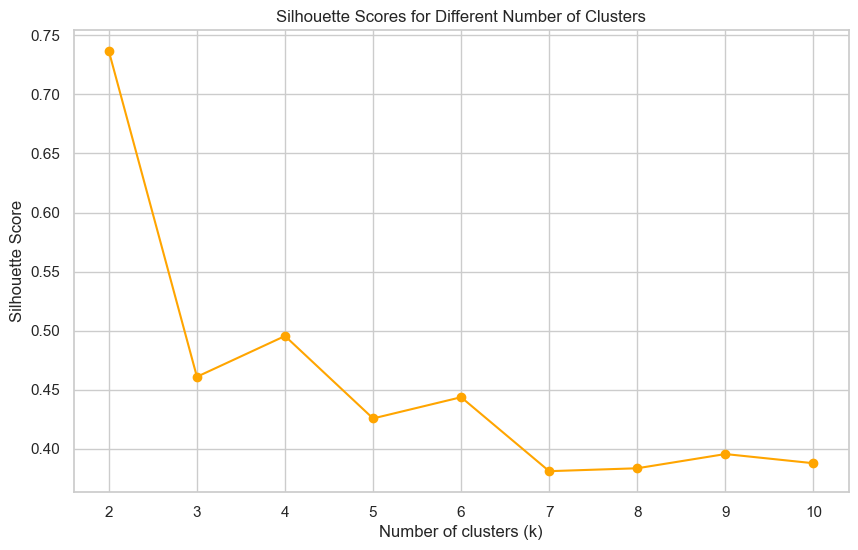

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [85]:
kmeans = KMeans(n_clusters= 6, max_iter= 50, random_state= 42)
kmeans.fit(X)
clusters = kmeans.labels_

In [86]:
kmeans_4cluster = datamart.copy()
kmeans_4cluster['Cluster'] = clusters
kmeans_4cluster.head()
kmeans_4cluster.groupby(['Cluster']).agg({
    'Recency': 'mean',
   'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(2)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0        254.16      1.00         90.92  32407
1        220.11      2.11        213.30   2813
2        454.85      1.00         98.17  20705
3        243.81      1.04       1738.99    632
4         86.55      1.00         95.25  33238
5        227.44      1.00        592.46   3996

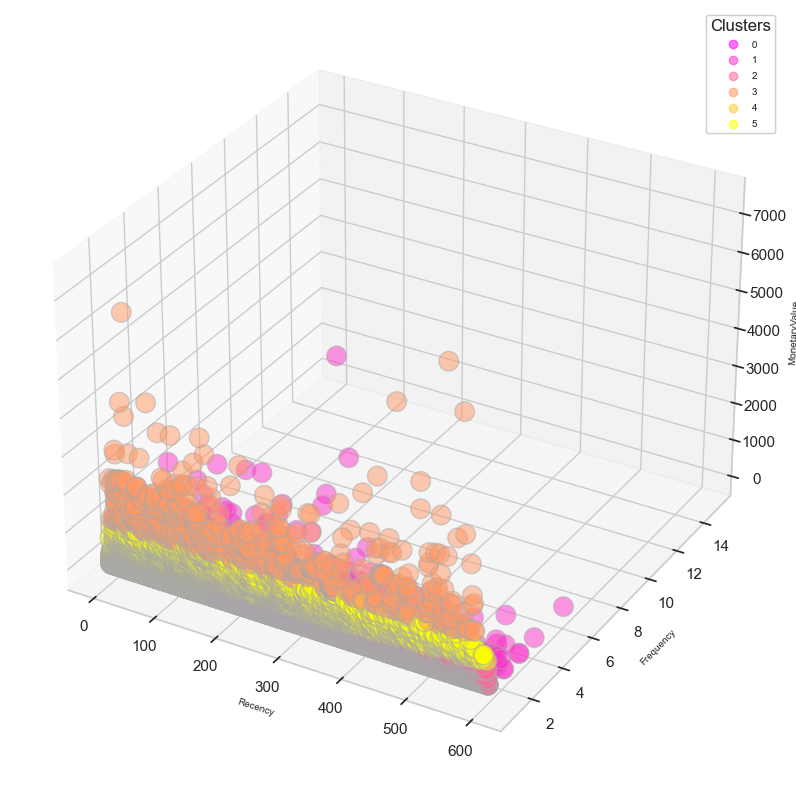

In [87]:
plt.rcParams["figure.figsize"] = (10, 10)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(kmeans_4cluster['Recency'], kmeans_4cluster['Frequency'], kmeans_4cluster['MonetaryValue'],
           c = kmeans_4cluster['Cluster'],
           s = 200,
           cmap = 'spring',
           alpha = 0.5,
           edgecolor = 'darkgray')

ax.set_xlabel('Recency', fontsize = 7)
ax.set_ylabel('Frequency', fontsize = 7)
ax.set_zlabel('MonetaryValue', fontsize = 7)

legend = ax.legend(*sc.legend_elements(), title="Clusters", loc="upper right", fontsize=7)
ax.add_artist(legend)


plt.show()

In [ ]:
fig = px.scatter_3d(kmeans_4cluster, x='Recency', y='Frequency', z='MonetaryValue', color='Cluster',
                    title='3D Scatter Plot of Customer Segments with k-means algorithm',
                     width=1000, height=800)

fig.show()

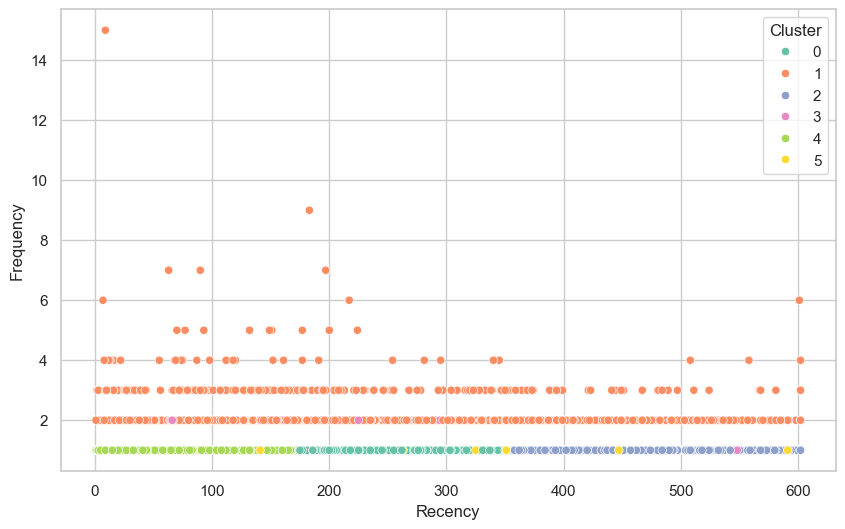

In [89]:
plt.figure(figsize = (10,6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=kmeans_4cluster, palette='Set2', legend='full')
plt.show()

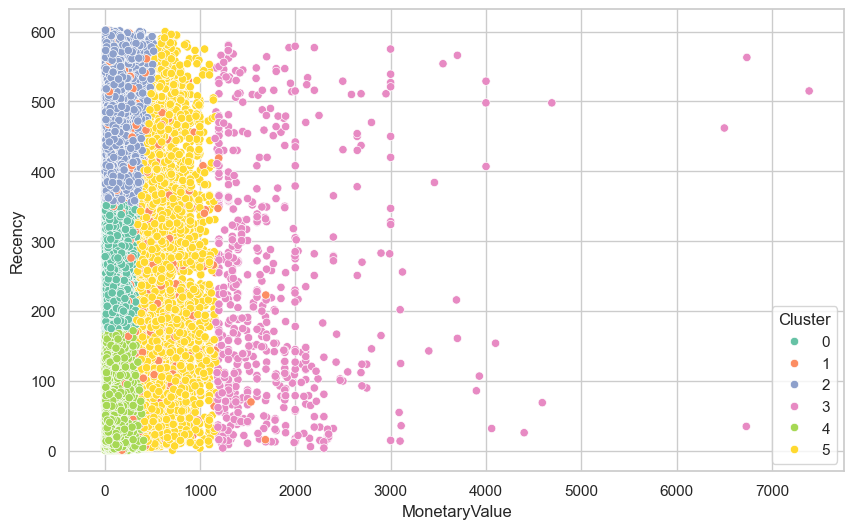

In [90]:
plt.figure(figsize = (10,6))
sns.scatterplot(x='MonetaryValue', y='Recency', hue='Cluster', data=kmeans_4cluster, palette='Set2', legend='full')
plt.show()

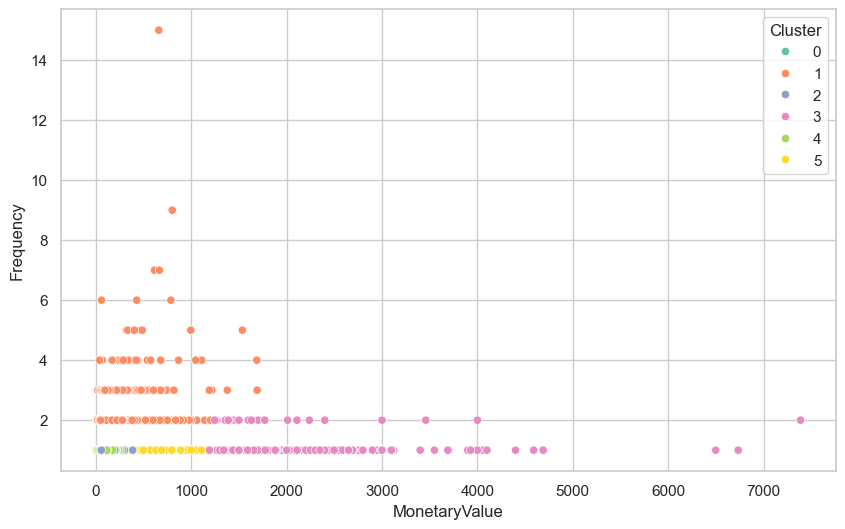

In [91]:
plt.figure(figsize = (10,6))
sns.scatterplot(x='MonetaryValue', y='Frequency', hue='Cluster', data=kmeans_4cluster, palette='Set2', legend='full')
plt.show()

# DBSCAN

In [ ]:
minPts = 3*2

nn = NearestNeighbors(n_neighbors=minPts).fit(X)
dist, idx = nn.kneighbors(X)
avg_dist = [d.mean() for d in dist]
avg_dist.sort(reverse=True)
trimmed_avg_dist = np.clip(avg_dist, 0, np.percentile(avg_dist, 95))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(trimmed_avg_dist) + 1), trimmed_avg_dist)
#plt.plot(list(range(1,X.shape[0]+1)), avg_dist)
#plt.plot(list(range(1, len(avg_dist) + 1)), avg_dist)
plt.axhline(y=0.7, color='r', linestyle='--')
plt.title('k distance graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.show()

In [ ]:
minPts = 3 * 2 

nn = NearestNeighbors(n_neighbors=minPts).fit(X)
distances, indices = nn.kneighbors(X)

# Średnia odległość do najbliższych sąsiadów
avg_distances = np.mean(distances, axis=1)
avg_distances.sort()

# Wykres k-odległości
plt.figure(figsize=(10, 6))
plt.plot(list(range(1,X.shape[0]+1)), avg_distances)
#plt.plot(range(1, len(avg_distances) + 1), avg_distances)
#plt.axhline(y=0.5, color='r', linestyle='--')  # Przykładowa wartość eps, dostosuj w zależności od wykresu
plt.title('k distance graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.show()

In [94]:
dbscan = DBSCAN(eps=0.5, min_samples=minPts) 
clusters = dbscan.fit_predict(X)

df_dbscan = datamart.copy()
df_dbscan['Cluster'] = clusters
df_dbscan.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,0
0000f46a3911fa3c0805444483337064,537,1,69.00,0
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,0
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,0


In [95]:
df_dbscan.groupby(['Cluster']).agg({
    'Recency': 'mean',
   'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(2)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
-1       247.74      2.57       1825.85    144
 0       237.30      1.00        124.70  90879
 1       221.63      2.00        197.01   2569
 2       196.80      3.00        244.60    158
 3       118.50      1.00       2475.39      6
 4       452.86      1.00       2652.28      7
 5       114.83      1.00       2730.88      6
 6        75.64      4.00        307.89     11
 7       520.50      1.00       2991.59      6
 8       575.40      3.00         63.66      5

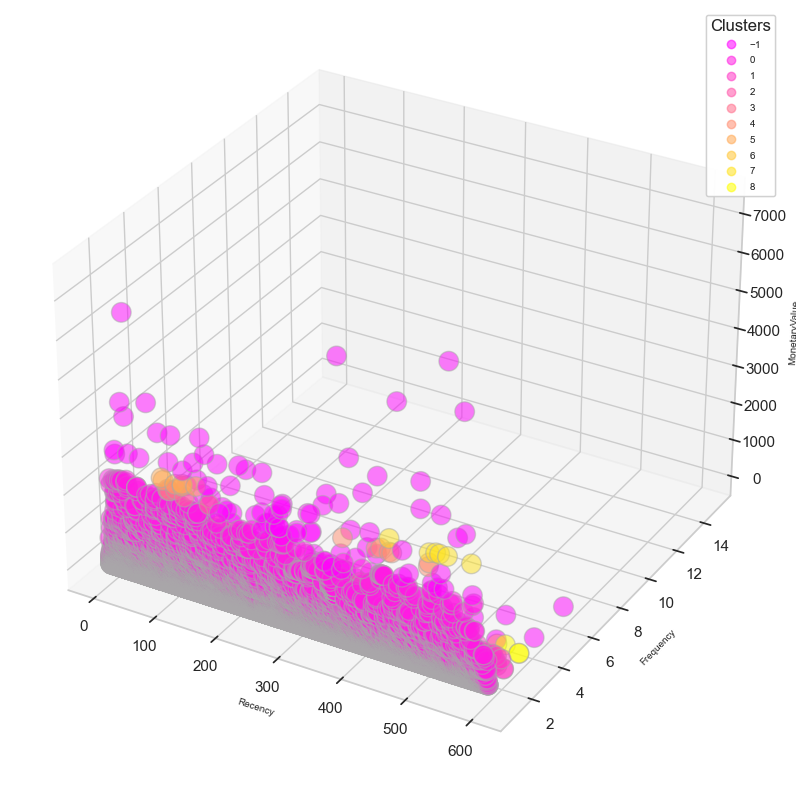

In [96]:
plt.rcParams["figure.figsize"] = (10, 10)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df_dbscan['Recency'], df_dbscan['Frequency'], df_dbscan['MonetaryValue'],
           c = df_dbscan['Cluster'],
           s = 200,
           cmap = 'spring',
           alpha = 0.5,
           edgecolor = 'darkgray')

ax.set_xlabel('Recency', fontsize = 7)
ax.set_ylabel('Frequency', fontsize = 7)
ax.set_zlabel('MonetaryValue', fontsize = 7)

legend = ax.legend(*sc.legend_elements(), title="Clusters", loc="upper right", fontsize=7)
ax.add_artist(legend)


plt.show()

In [ ]:
fig = px.scatter_3d(df_dbscan, x='Recency', y='Frequency', z='MonetaryValue', color='Cluster',
                    title='3D Scatter Plot of Customer Segments with DBSCAN algorithm ',
                     width=1000, height=800)

fig.show()

# GMM

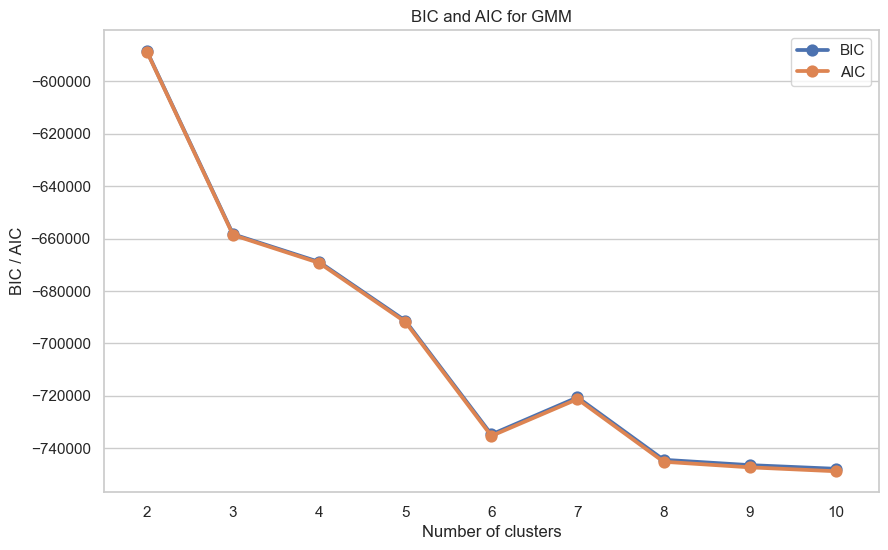

In [98]:
bics = []
aics = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=num_clusters, max_iter=50, random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))
    aics.append(gmm.aic(X))

plt.figure(figsize=(10, 6))
sns.pointplot(x=range_n_clusters, y=bics, markers='o', label='BIC')
sns.pointplot(x=range_n_clusters, y=aics, markers='o', label='AIC')
plt.title('BIC and AIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('BIC / AIC')
plt.legend()
plt.show()


In [99]:
gmm = GaussianMixture(n_components=6, max_iter=50, random_state=42)
gmm.fit(X)
clusters = gmm.predict(X)

gmm_6clusters = datamart.copy()
gmm_6clusters['Cluster'] = clusters

gmm_6clusters.groupby(['Cluster']).agg({
    'Recency': ['mean', 'min', 'max'], 
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'min', 'max', 'count']
}).round(2)

Recency          Frequency MonetaryValue                       
           mean min  max      mean          mean     min     max  count
Cluster                                                                
0        246.99   1  601      1.00         42.06    0.85    90.0  43344
1        221.95   1  602      2.00        196.03   11.98   929.9   2566
2        330.51   1  602      1.00        166.48    4.90   360.0  22187
3        218.37   2  602      2.83        998.35   20.70  7388.0    322
4        106.33   1  240      1.00        115.40   59.89   209.0  19897
5        259.09   1  600      1.00        652.86  279.00  2550.0   5475

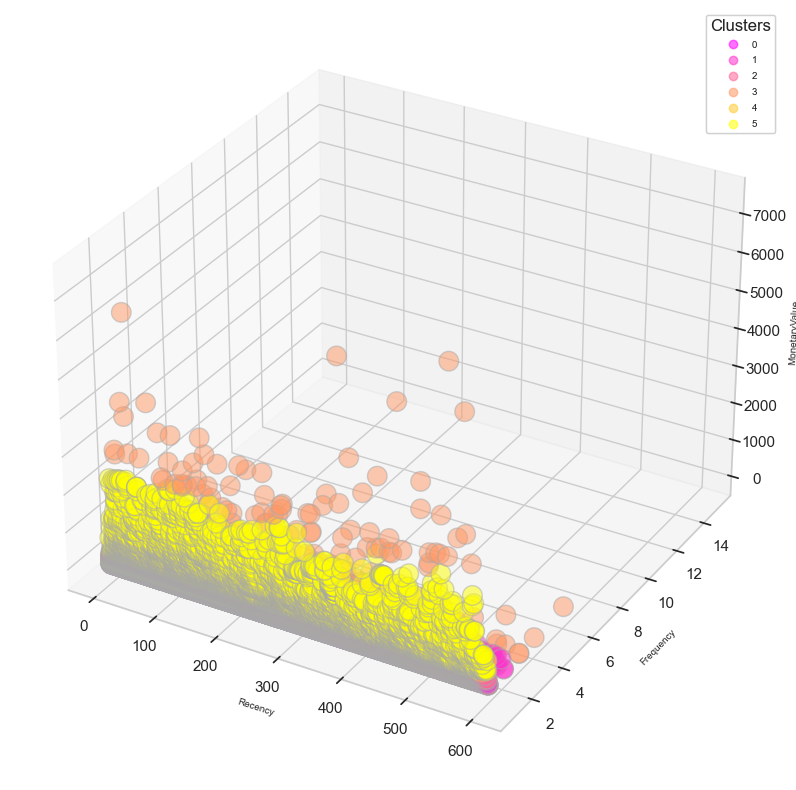

In [100]:
plt.rcParams["figure.figsize"] = (10, 10)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(gmm_6clusters['Recency'], gmm_6clusters['Frequency'], gmm_6clusters['MonetaryValue'],
           c = gmm_6clusters['Cluster'],
           s = 200,
           cmap = 'spring',
           alpha = 0.5,
           edgecolor = 'darkgray')

ax.set_xlabel('Recency', fontsize = 7)
ax.set_ylabel('Frequency', fontsize = 7)
ax.set_zlabel('MonetaryValue', fontsize = 7)

legend = ax.legend(*sc.legend_elements(), title="Clusters", loc="upper right", fontsize=7)
ax.add_artist(legend)


plt.show()

In [ ]:
fig = px.scatter_3d(gmm_6clusters, x='Recency', y='Frequency', z='MonetaryValue', color='Cluster',
                    title='3D Scatter Plot of Customer Segments with DBSCAN algorithm ',
                     width=1000, height=800)

fig.show()

## More data and PCA

In [ ]:
df_olist.head()

In [ ]:
df = df_olist.copy()
df.drop(columns=['customer_id','order_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                 'order_delivered_customer_date', 'order_estimated_delivery_date','order_item_id', 'product_id',  'seller_id', 'customer_zip_code_prefix',
                 'shipping_limit_date','price', 'freight_value', 'product_category_name','product_description_lenght','product_name_lenght',
                 'product_photos_qty','product_weight_g','product_length_cm','product_height_cm', 'product_width_cm', 'payment_value', 'review_id', 
                 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'payment_sequential','customer_city'], 
                 inplace=True)
df.head(3)
df = df.dropna(subset=['payment_type', 'payment_installments'])
median_review_score = df['review_score'].median()
df['review_score'].fillna(median_review_score, inplace=True)
df.isnull().sum()

In [106]:
datamart.reset_index(inplace=True)
df_merged = pd.merge(datamart, df, left_on='CustomerID', right_on='customer_unique_id', how='left').drop('customer_unique_id', axis='columns')
df_merged.set_index('CustomerID', inplace=True)

In [107]:
def classify_cat(x):

    if x in ['office_furniture', 'furniture_decor', 'furniture_living_room', 'kitchen_dining_laundry_garden_furniture', 'bed_bath_table', 'home_comfort', 'home_comfort_2', 'home_construction', 'garden_tools', 'furniture_bedroom', 'furniture_mattress_and_upholstery']:
        return 'Furniture'
    
    elif x in ['auto', 'computers_accessories', 'musical_instruments', 'consoles_games', 'watches_gifts', 'air_conditioning', 'telephony', 'electronics', 'fixed_telephony', 'tablets_printing_image', 'computers', 'small_appliances_home_oven_and_coffee', 'small_appliances', 'audio', 'signaling_and_security', 'security_and_services']:
        return 'Electronics'
    
    elif x in ['fashio_female_clothing', 'fashion_male_clothing', 'fashion_bags_accessories', 'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach', 'fashion_childrens_clothes', 'baby', 'cool_stuff', ]:
        return 'Fashion'
    
    elif x in ['housewares', 'home_confort', 'home_appliances', 'home_appliances_2', 'flowers', 'costruction_tools_garden', 'garden_tools', 'construction_tools_lights', 'costruction_tools_tools', 'luggage_accessories', 'la_cuisine', 'pet_shop', 'market_place']:
        return 'Home & Garden'
    
    elif x in ['sports_leisure', 'toys', 'cds_dvds_musicals', 'music', 'dvds_blu_ray', 'cine_photo', 'party_supplies', 'christmas_supplies', 'arts_and_craftmanship', 'art']:
        return 'Entertainment'
    
    elif x in ['health_beauty', 'perfumery', 'diapers_and_hygiene']:
        return 'Beauty & Health'
    
    elif x in ['food_drink', 'drinks', 'food']:
        return 'Food & Drinks'
    
    elif x in ['books_general_interest', 'books_technical', 'books_imported', 'stationery']:
        return 'Books & Stationery'
    
    elif x in ['construction_tools_construction', 'construction_tools_safety', 'industry_commerce_and_business', 'agro_industry_and_commerce']:
        return 'Industry & Construction'


In [108]:
df_merged['product_category'] = df_merged['product_category_name_english'].apply(classify_cat)
df_merged.drop(['product_category_name_english'], axis=1, inplace=True)

In [109]:
df_merged.head()

,Recency,Frequency,MonetaryValue,payment_type,payment_installments,review_score,customer_state,product_category
CustomerID,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,credit_card,8.0,5.0,SP,Furniture
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,credit_card,1.0,4.0,SP,Beauty & Health
0000f46a3911fa3c0805444483337064,537,1,69.00,credit_card,8.0,3.0,SC,Books & Stationery
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,credit_card,4.0,4.0,PA,Electronics
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,credit_card,6.0,5.0,SP,Electronics


In [110]:
numerical_columns = ['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score']  
categorical_columns = ['product_category', 'payment_type', 'customer_state']  

categorical_transformer = OneHotEncoder(handle_unknown='ignore')  
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

preprocessed_data = preprocessor.fit_transform(df_merged)

numerical_features = numerical_columns
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_features = list(numerical_features) + list(categorical_features)
df_transformed = pd.DataFrame(preprocessed_data.toarray(), columns=all_features, index = df_merged.index)

In [111]:
numerical_columns = ['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score']  
categorical_columns = ['product_category', 'payment_type', 'customer_state']  

categorical_transformer = OneHotEncoder(handle_unknown='ignore')  
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

preprocessed_data = preprocessor.fit_transform(df_merged)

numerical_features = numerical_columns
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_features = list(numerical_features) + list(categorical_features)
df_transformed = pd.DataFrame(preprocessed_data.toarray(), columns=all_features, index = df_merged.index)

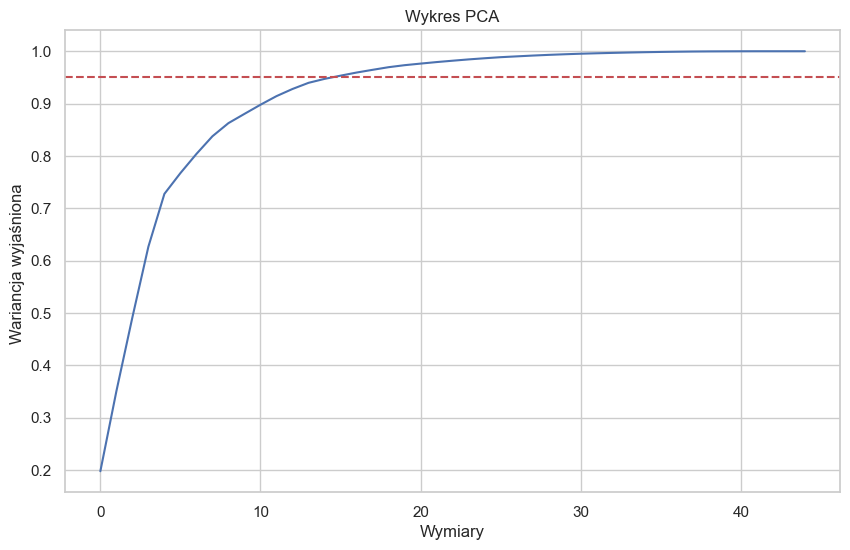

Wybrana liczba składowych dla 95% wyjaśnionej wariancji: 16


In [112]:
pca = PCA()
principal_components = pca.fit_transform(df_transformed)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Wymiary')
plt.ylabel('Wariancja wyjaśniona ')
plt.title('Wykres PCA')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  
plt.show()

n_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
print(f'Wybrana liczba składowych dla 95% wyjaśnionej wariancji: {n_components}')


In [113]:
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df_transformed)
columns = [f'PC{i+1}' for i in range(n_components)]
df_pca_transformed = pd.DataFrame(principal_components, columns=columns, index=df_transformed.index)
df_pca16_merged = pd.merge(df_merged, df_pca_transformed, left_index=True, right_index=True)


In [114]:
df_pca16_merged.head()
df_pca_transformed.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
CustomerID,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1.127273,0.237778,-0.358394,-1.392320,-1.168271,0.577330,0.696019,0.047803,0.536138,0.056796,-0.035935,-0.050991,-0.007866,-0.039530,-0.003835,0.001702
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.908895,0.498804,0.488837,-0.427540,-0.102731,0.677341,-0.223811,0.220697,-0.415673,-0.517225,0.476307,-0.405525,-0.150238,-0.019352,0.015491,-0.025522
0000f46a3911fa3c0805444483337064,1.156379,-2.267259,-0.419464,0.612077,-1.162872,-0.256200,0.090814,-0.164952,-0.283177,-0.021638,-0.034593,0.029631,0.064518,0.319096,-0.105016,0.592223
0000f6ccb0745a6a4b88665a16c9f078,-0.062274,-0.680545,-0.227331,0.049226,-0.521098,-0.400069,-0.592857,-0.544146,0.241100,-0.027880,-0.025664,-0.038339,-0.013614,0.199467,-0.029449,0.101897
0004aac84e0df4da2b147fca70cf8255,0.840335,-0.264789,-0.851076,-0.512355,-0.384783,0.452768,-0.333711,-0.867191,0.255809,0.040448,0.006059,-0.028786,-0.026675,-0.070084,0.009019,-0.018849


In [115]:
X_pca = df_pca_transformed.copy()
X_pca.describe().round(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
count,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00,96956.00
mean,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.18,1.03,0.99,0.97,0.84,0.53,0.51,0.49,0.42,0.35,0.35,0.34,0.31,0.29,0.23,0.21
min,-1.25,-3.43,-2.21,-3.42,-9.66,-1.06,-1.47,-2.28,-0.84,-1.06,-1.03,-0.45,-0.56,-0.58,-0.73,-0.56
25%,-0.78,-0.67,-0.67,-0.62,-0.36,-0.44,-0.35,-0.35,-0.41,-0.08,-0.07,-0.07,-0.15,-0.16,-0.03,-0.05
50%,-0.37,0.02,-0.16,-0.10,0.02,-0.22,-0.07,0.08,-0.07,-0.02,-0.02,-0.03,-0.04,-0.04,0.01,-0.02
75%,0.39,0.63,0.45,0.48,0.35,0.57,0.32,0.37,0.34,0.05,0.03,0.04,-0.00,0.22,0.02,0.05
max,26.51,23.09,4.21,25.06,24.70,2.22,1.97,3.30,0.90,1.12,1.08,1.05,1.01,0.64,0.73,0.75


## GMM with PCA with 16 dimensions

In [116]:
bics = []
aics = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:
    gmm_PCA = GaussianMixture(n_components=num_clusters, max_iter=50, random_state=42)
    gmm_PCA.fit(X_pca)
    bics.append(gmm_PCA.bic(X_pca))
    aics.append(gmm_PCA.aic(X_pca))

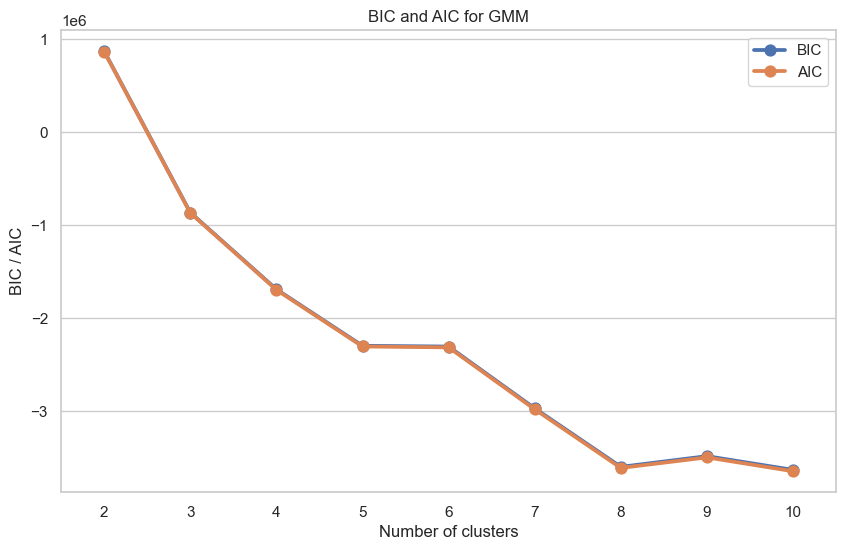

In [117]:
plt.figure(figsize=(10, 6))
sns.pointplot(x=range_n_clusters, y=bics, markers='o', label='BIC')
sns.pointplot(x=range_n_clusters, y=aics, markers='o', label='AIC')
plt.title('BIC and AIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('BIC / AIC')
plt.legend()
plt.show()

In [118]:
gmm_PCA = GaussianMixture(n_components=8, max_iter=50, random_state=42)
gmm_PCA.fit(X_pca)
clusters = gmm_PCA.predict(X_pca)

gmm_PCA_cluster = df_merged.copy()
gmm_PCA_cluster['Cluster'] = clusters

In [119]:
gmm_PCA_cluster.head()
gmm_PCA_cluster.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'payment_type' : pd.Series.mode,
    'payment_installments' : 'mean',
    'review_score' : 'mean',
    'customer_state' : pd.Series.mode,
    'product_category' : [pd.Series.mode, 'count']
}).round(2)

Recency Frequency MonetaryValue payment_type payment_installments  \
           mean      mean          mean         mode                 mean   
Cluster                                                                     
0        238.76      1.00        138.54  credit_card                 3.90   
1        225.80      1.00        113.06  credit_card                 3.34   
2        244.57      1.00         89.15       boleto                 1.00   
3        235.98      1.20        132.91       boleto                 1.44   
4        255.55      1.00        126.41  credit_card                 3.21   
5        224.98      2.01        337.41  credit_card                 3.49   
6        231.40      1.00        127.43  credit_card                 3.71   
7        245.20      1.00        229.29  credit_card                 3.71   

        review_score customer_state product_category         
                mean           mode             mode  count  
Cluster                                                      
0               4.03             RS      Electronics  16313  
1               4.48             SP      Electronics  32474  
2               4.13             SP        Furniture  12242  
3               4.12             SP      Electronics  12011  
4               4.13             SP    Entertainment  12334  
5               4.20             SP        Furniture   4881  
6               1.00             SP      Electronics   3648  
7               4.20             MG    Entertainment   3053

### Wnioski dla klastrowania GMM:

#### Klaster 0
- **Profil:** Klienci z niską częstotliwością zakupów i umiarkowaną wartością transakcji.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z Rio Grande do Sul (RS).
- **Produkty:** Elektronika.

#### Klaster 1
- **Profil:** Klienci z niską częstotliwością zakupów i niską wartością transakcji, ale z najwyższą średnią oceną 4.49.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Elektronika.

#### Klaster 2
- **Profil:** Klienci z niską częstotliwością zakupów i najniższą wartością transakcji.
- **Typowe płatności:** Boleto.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Meble.

#### Klaster 3
- **Profil:** Klienci z nieco wyższą częstotliwością zakupów i umiarkowaną wartością transakcji.
- **Typowe płatności:** Boleto.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Elektronika.

#### Klaster 4
- **Profil:** Klienci z niską częstotliwością zakupów i umiarkowaną wartością transakcji.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Rozrywka.

#### Klaster 5
- **Profil:** Klienci z najwyższą wartością transakcji i najwyższą częstotliwością zakupów.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Meble.

#### Klaster 6
- **Profil:** Klienci z niską częstotliwością zakupów i umiarkowaną wartością transakcji, ale z najniższą średnią oceną (1.00).
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Elektronika.

#### Klaster 7
- **Profil:** Klienci z niską częstotliwością zakupów i wysoką wartością transakcji.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z Minas Gerais (MG).
- **Produkty:** Rozrywka.

### Podsumowanie:
- **Klaster 1** i **Klaster 5** wyróżniają się wysokim poziomem satysfakcji klienta, natomiast **Klaster 6** wskazuje na potrzebę poprawy jakości obsługi lub produktów.
- Większość klientów dokonuje płatności kartą kredytową, jednak grupy korzystające z boleto (Klastry 2 i 3) mają niższą wartość transakcji.
- Klienci z São Paulo dominują w kilku klastrach, co wskazuje na regionalne znaczenie tego rynku.


## Kmeans with 16 dim

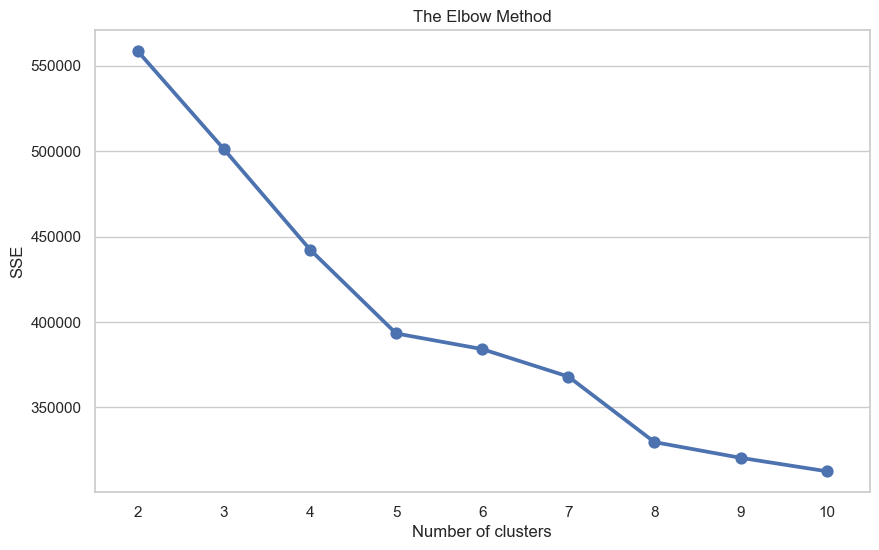

In [120]:
#Elbow Curve

sse = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9 ,10]

for num_clusters in range_n_clusters:
    kmeans =KMeans(n_clusters=num_clusters, max_iter= 50, random_state= 42)
    kmeans.fit(X_pca)

    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
sns.pointplot(x=range_n_clusters, y=sse, markers='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
#Silhouette Analysis
silhouette_scores = []

for num_clusters in range_n_clusters:
    kmeans =KMeans(n_clusters=num_clusters, max_iter= 50, random_state= 42)
    kmeans.fit(X_pca)
    cluster_labels = kmeans.labels_
    #silhouette score
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print('For n_clusters = {0}, the silhouette score is {1}'. format(num_clusters, silhouette_avg))

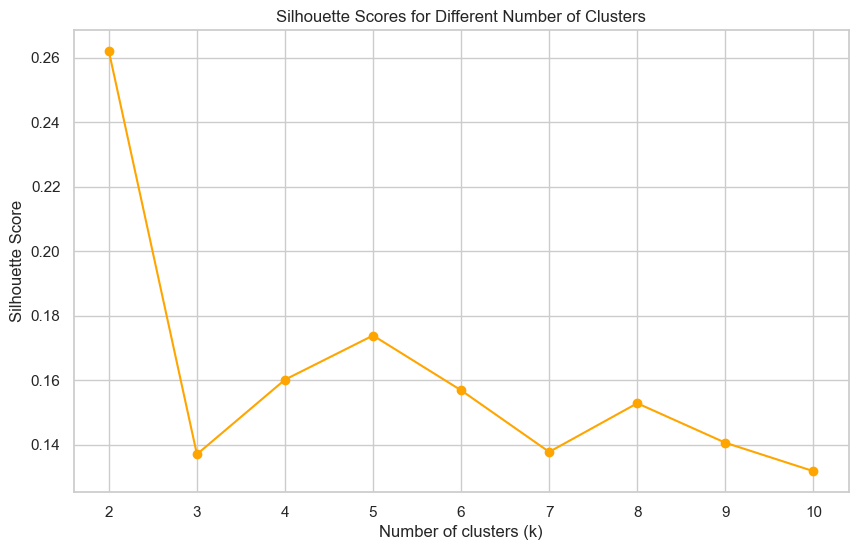

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [123]:
kmeans = KMeans(n_clusters= 6, max_iter= 50, random_state= 42)
kmeans.fit(X_pca)
clusters = kmeans.labels_

In [124]:
kmeans_PCA_cluster = df_merged.copy()
kmeans_PCA_cluster['Cluster'] = clusters

kmeans_PCA_cluster.head()
kmeans_PCA_cluster.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'payment_type' : pd.Series.mode,
    'payment_installments' : 'mean',
    'review_score' : 'mean',
    'customer_state' : pd.Series.mode,
    'product_category' : [pd.Series.mode, 'count']
}).round(2)

Recency Frequency MonetaryValue payment_type payment_installments  \
           mean      mean          mean         mode                 mean   
Cluster                                                                     
0        240.92      1.02        367.93  credit_card                 8.39   
1        212.12      2.24        221.40  credit_card                 3.04   
2        387.78      1.00         92.53  credit_card                 2.12   
3        412.95      1.02        104.08  credit_card                 3.10   
4        123.42      1.00         92.06  credit_card                 1.93   
5        158.23      1.00         99.16  credit_card                 2.21   

        review_score customer_state product_category         
                mean           mode             mode  count  
Cluster                                                      
0               4.36             SP      Electronics  11455  
1               4.27             SP        Furniture   5632  
2               4.74             SP      Electronics  25848  
3               1.89             SP        Furniture   6295  
4               4.75             SP      Electronics  35334  
5               1.82             SP      Electronics  12392

### Wnioski dla klastrowania K-means

#### Klaster 0
- **Profil:** Klienci z niską częstotliwością zakupów i wysoką wartością transakcji.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Meble.
- **Dodatkowe:** Średnia ocena 4.32 sugeruje wysokie zadowolenie z zakupów.

#### Klaster 1
- **Profil:** Klienci z niską częstotliwością zakupów i niską wartością transakcji, ale z najwyższą średnią oceną 4.63.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Elektronika.
- **Dodatkowe:** Najliczniejszy klaster, co wskazuje na szeroką bazę klientów w tej grupie.

#### Klaster 2
- **Profil:** Klienci z niską częstotliwością zakupów i niską wartością transakcji.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Elektronika.
- **Dodatkowe:** Średnia ocena 4.67, co wskazuje na wysokie zadowolenie.

#### Klaster 3
- **Profil:** Klienci z niską częstotliwością zakupów i umiarkowaną wartością transakcji.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Elektronika.
- **Dodatkowe:** Średnia ocena 1.57, co wskazuje na niskie zadowolenie i potencjalne problemy z jakością obsługi lub produktów.

#### Klaster 4
- **Profil:** Klienci z nieco wyższą częstotliwością zakupów i bardzo wysoką wartością transakcji.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Elektronika.
- **Dodatkowe:** Średnia ocena 4.04, co wskazuje na umiarkowane zadowolenie.

#### Klaster 5
- **Profil:** Klienci z najwyższą częstotliwością zakupów i umiarkowaną wartością transakcji.
- **Typowe płatności:** Karta kredytowa.
- **Lokalizacja:** Głównie z São Paulo (SP).
- **Produkty:** Meble.
- **Dodatkowe:** Średnia ocena 4.21, co sugeruje wysokie zadowolenie z zakupów.

### Podsumowanie:
- **Klastry 1 i 2** wyróżniają się wysokim poziomem satysfakcji klienta, natomiast **Klaster 3** wskazuje na potrzebę poprawy jakości obsługi lub produktów.
- Większość klientów dokonuje płatności kartą kredytową.
- Klienci z São Paulo dominują we wszystkich klastrach, co wskazuje na regionalne znaczenie tego rynku.
